Ensure you are using latest version of safetensors to be compatible with HuggingFace model.

In [ ]:
%pip install --upgrade transformers safetensors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 132.3 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.55.0
    Uninstalling transformers-4.55.0:
      Successfully uninstalled transformers-4.55.0


In [ ]:
# Importing all the important libraries, modules and functions
from absl import flags
import collections
import json
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import transformers
from tf_keras.layers import Dense, Input, Embedding, Conv1D, GlobalMaxPooling1D, Dropout, Concatenate, Flatten
from tf_keras import models, layers, initializers, losses, metrics, callbacks, optimizers
from tf_keras.callbacks import EarlyStopping
from transformers import TFDistilBertModel, DistilBertConfig, DistilBertTokenizer, AutoTokenizer
import logging
import requests
from tf_keras.metrics import Precision, Recall, F1Score, AUC
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, hamming_loss


# Configuration flags
The original GoEmotions code (used as a resource for this) was intended to be run as a command-line program, and users passed in their customized flags on the command prompt. Default flags were defined using the absl module. To simplify our customizations, we reused absl to hold the configuration, but we are not using it for command line processing; the default values we are setting are the only values we are actuallty using.

Note that when you are running this code, the file locations may need to be adjusted based on where they are actually located on your machine. These parameters include:


*   emotion_file
*   sentiment_file
*   output_dir
*   data_dir
*   train_fname
*   dev_fname
*   test_fname




In [ ]:
FLAGS = flags.FLAGS

# Remove all previously defined flags to avoid duplicates if rerunning cell in Jupyter.
# Note that this would prevent any actual command-line processing from occurring.
for name in list(flags.FLAGS):
    delattr(flags.FLAGS, name)

# The file that contains a list of all emotions in plaintext, pulled from the GoEmotions repo.
flags.DEFINE_string("emotion_file", "/content/emotions.txt",
                    "URL to file containing a list of emotions.")

# This can be false because neutral is in the above emotions file.
flags.DEFINE_bool(
    "add_neutral", False,
    "Whether to add a neutral label in addition to the other labels "
    "(necessary when neutral is not part of the emotion file).")

# to set to True since the data can have multiple emotion categories.
flags.DEFINE_boolean("multilabel", True,
                     "Whether to perform multilabel classification.")

# If 1, regularization processing is turned on
flags.DEFINE_float("sentiment", 1,
                   "Regularization parameter for sentiment relations.")

flags.DEFINE_float("correlation", 1,
                   "Regularization parameter for emotion correlations.")

flags.DEFINE_string("sentiment_file", "/content/sentiment_dict.json",
                    "Dictionary of sentiment categories.")

flags.DEFINE_integer(
    "max_seq_length", 50,
    "The maximum total input sequence length after WordPiece tokenization. "
    "Sequences longer than this will be truncated, and sequences shorter "
    "than this will be padded.")

flags.DEFINE_integer(
    "embedding_dim", 100,
    "The dimensions of the embedded sequence")

flags.DEFINE_string(
    "output_dir", "/content/output",
    "The output directory where the model checkpoints will be written.")

flags.DEFINE_string(
    "data_dir", "/content/data",
    "The input data dir. Should contain the full dataset files.")

flags.DEFINE_bool(
    "do_lower_case", True,
    "Whether to lower case the input text. Should be True for uncased "
    "models and False for cased models.")

flags.DEFINE_integer("num_train_epochs", 20,
                   "Maximum number of training epochs to perform (may do less if model converges sooner).")

flags.DEFINE_string("train_fname", "/content/train.tsv",
                    "The name/location of the training file.")

flags.DEFINE_string("dev_fname", "/content/dev.tsv", "The name/location of the dev file.")

flags.DEFINE_string("test_fname", "/content/test.tsv", "The name/location of the test file.")

flags.DEFINE_integer("train_batch_size", 16, "Total batch size for training.")

flags.DEFINE_float(
    "warmup_proportion", 0.1,
    "Used for custom learning rate schedule. Percentage of time custom schedule should warmup.")

flags.DEFINE_float("learning_rate", 5e-5, "The initial learning rate for AdamW.")

flags.DEFINE_integer("save_summary_steps", 100,
                     "How often to save model summaries.")

flags.DEFINE_bool("do_train", True,
                  "Whether to run training & evaluation on the dev set.")

flags.DEFINE_bool("calculate_metrics", True,
                  "Whether to calculate performance metrics on the test set ")

flags.DEFINE_bool("do_predict", True,
                  "Whether to run the model in inference mode on the test set.")

flags.DEFINE_string(
    "init_checkpoint", None,
    "Initial checkpoint (usually from a pre-trained BERT model).")

flags.DEFINE_integer("eval_steps", None,
                     "How many steps to take to go over the eval set.")

FLAGS.mark_as_parsed() # Mark flags as already parsed, since we aren't actually running from command-line

# Logging

In [ ]:
# Set Tensorflow log level
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0"

# Set logging module log level
logging.basicConfig(level=logging.INFO)

# Additional set-up

In [ ]:
# Make sure output directory exists
tf.io.gfile.makedirs(FLAGS.output_dir)

# Set variable
model_dir = FLAGS.output_dir

# Emotion labels
All emotion labels to be used are defined in emotions.txt file. This opens the file and loads the emotions list from it.

In [ ]:
# Functionality from the original code to load emotion categories
all_emotions = None
idx2emotion = None
num_labels = 0

with open(FLAGS.emotion_file, "r") as f:
    all_emotions = f.read().splitlines()
    if FLAGS.add_neutral:
      all_emotions = all_emotions + ["neutral"]
    idx2emotion = {i: e for i, e in enumerate(all_emotions)}
    num_labels = len(all_emotions)
    print("%d labels" % num_labels)
    print("Multilabel: %r" % FLAGS.multilabel)

28 labels
Multilabel: True


# Full dataset examination

## Emotion distribution
This function processes the full dataset and determines the spread of instances of that emotion across the 28 categories. This provides the information both in text and visual formats but we chose to remove the 'neutral' category from our distribution representation because the 'neutral' criteria was too huge to show any relevant distribution across all the other minority classes. Therefore, to show a good representation across all the non-neutral emotion categories, we have opted to remove 'neutral' from this distribution graph.

<class 'pandas.core.frame.DataFrame'>
Index: 211225 entries, 0 to 69999
Data columns (total 37 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   text                  211225 non-null  object 
 1   id                    211225 non-null  object 
 2   author                211225 non-null  object 
 3   subreddit             211225 non-null  object 
 4   link_id               211225 non-null  object 
 5   parent_id             211225 non-null  object 
 6   created_utc           211225 non-null  float64
 7   rater_id              211225 non-null  int64  
 8   example_very_unclear  211225 non-null  bool   
 9   admiration            211225 non-null  int64  
 10  amusement             211225 non-null  int64  
 11  anger                 211225 non-null  int64  
 12  annoyance             211225 non-null  int64  
 13  approval              211225 non-null  int64  
 14  caring                211225 non-null  int64  
 15  confus

/tmp/ipython-input-266825182.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')


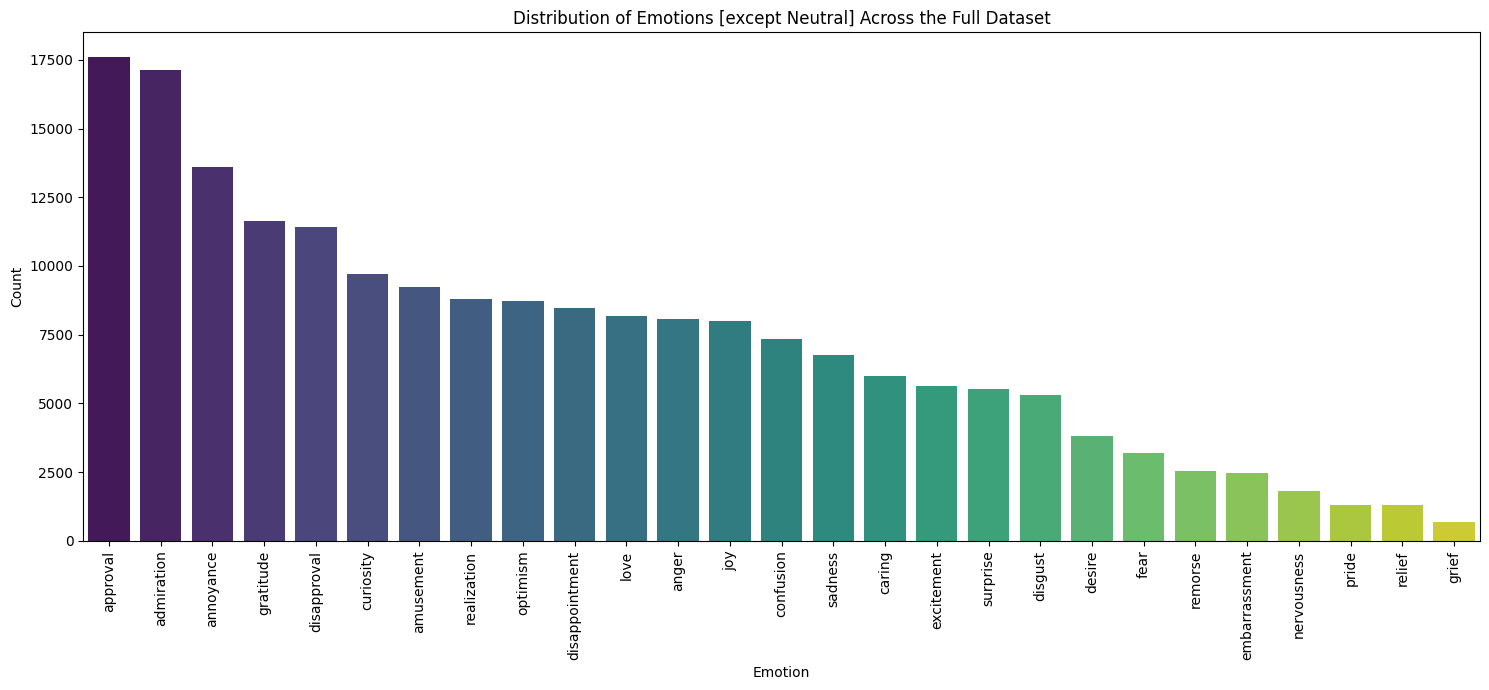

None
Emotion distribution saved as 'emotion_distribution.png'


In [ ]:
# Show the distribution of the full dataset to highlight any imbalance
# Load the full dataset
def emo_distribution():
    dfs = []
    for filename in os.listdir(FLAGS.data_dir):
      if filename.endswith(".csv"):
        dfs.append(
          pd.read_csv(os.path.join(FLAGS.data_dir, filename), encoding="utf-8"))
    df_full = pd.concat(dfs)
    # printing info about the complete dataset
    print(df_full.info())
    print("===================================================================")
    # printing the first 5 rows to identify which row is the start of emotions
    print(df_full.head())

    # Identify the columns representing emotions (starting from 'admiration')
    # but not including 'neutral'
    emotion_columns = df_full.columns[df_full.columns.get_loc('admiration'):-1]

    # Calculate the sum of each emotion column to get the total count for each emotion
    emotion_counts = df_full[emotion_columns].sum().sort_values(ascending=False)

    # Create a bar plot of the emotion distribution
    plt.figure(figsize=(15, 7))
    sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')
    plt.title('Distribution of Emotions [except Neutral] Across the Full Dataset')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('emotion_distribution.png')
    plt.show()

emotion_distribution = emo_distribution() # to display the distribution
print(emotion_distribution)
print("Emotion distribution saved as 'emotion_distribution.png'")

As can be seen from the above graph, the highest number of examples of (non-neutral) emotions includes approval and admiration with around 17,500 examples. On the lower end are pride, relief, and grief, which have less than 2,500 examples in comparison. This graph shows signs of a highly imbalanced dataset which would cause problems in giving us the desired results later on. Additionally, due to this imbalanced distribution, we have to use weighted-loss regularization on top of other existing regularizations.

# Class imbalance weights
Based on the number of samples per class, implements a weighting algorithm to be used by the loss function.

In [ ]:
# Handling class imbalance through class weights to be used in Regularized Loss Function class
def class_weights():
    dfs = []
    for filename in os.listdir(FLAGS.data_dir):
      if filename.endswith(".csv"):
        dfs.append(
          pd.read_csv(os.path.join(FLAGS.data_dir, filename), encoding="utf-8"))
    df_full = pd.concat(dfs)
    emotion_columns = df_full.columns[df_full.columns.get_loc('admiration'):]
    # Calculate the sum of each emotion column to get the total count for each emotion
    emotion_counts = df_full[emotion_columns].sum().values
    # Now calculate weights
    total_samples_from_df = sum(emotion_counts)
    num_classes_from_df = len(emotion_counts)

    class_weights = []
    for count in emotion_counts:
        weight = total_samples_from_df / (num_classes_from_df * (count + 1e-6)) # to avoid division by zero
        class_weights.append(weight)

    return class_weights

class_weights = class_weights()

# Sentiment relationship grouping
This loads a pre-defined file that groups the 28 emotions categories into higher level categories (like positive, negative, and ambiguious). This is also used to control weights and bias.

In [ ]:
# From the original code. This creates an emotion distance matrix for sentiment regularization.
# For the matrix:
# 1, they are in the same sentiment group.
# 0, no label
# -1, they are in different groups
def get_sent_rels(emotions):
  """Get emotion distance matrix for sentiment regularization."""
  with open(FLAGS.sentiment_file) as f:
    sent_dict = json.loads(f.read())

  emotion2sentiment = {}
  for k, v in sent_dict.items():
    for e in v:
      # no emotion should be in two categories
      assert e not in emotion2sentiment
      emotion2sentiment[e] = k
  rels = []
  for e1 in emotions:
    e1_rels = []
    for e2 in emotions:
      if e1 not in emotion2sentiment or e2 not in emotion2sentiment:
        e1_rels.append(0)
      elif emotion2sentiment[e1] != emotion2sentiment[e2]:
        e1_rels.append(-1)
      elif emotion2sentiment[e1] == emotion2sentiment[e2]:
        e1_rels.append(1)
    rels.append(e1_rels)
  return rels


# sentiment is emotional tone of data
sentiment = FLAGS.sentiment

print("Getting distance matrix...")
print(all_emotions)
empty_rels = [[0] * num_labels] * num_labels # construct placeholder for empty matrix
if sentiment == 0: # if 0, don't bother making matrix
    sent_rels = empty_rels
else:
    sent_rels = get_sent_rels(all_emotions) # otherwise, get matrix for sentiment

print(sent_rels)

Getting distance matrix...
['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']
[[1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, -1, -1, 0], [1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, -1, -1, 0], [-1, -1, 1, 1, -1, -1, -1, -1, -1, 1, 1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, 0], [-1, -1, 1, 1, -1, -1, -1, -1, -1, 1, 1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, 0], [1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, -1, -1, 0], [1, 1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, -1, -1, 0], [-1, -1, -1, -1, -1, -1, 1, 1,

# Correlation matrix
Finds relationship between when emotions appear together. Used in algorithm to add weights based on emotion correlations. Also displays data and visualizations about emotion correlation.

Getting correlation matrix...
                admiration  amusement     anger  annoyance  approval  \
admiration        1.000000  -0.031093 -0.053570  -0.066833 -0.003953   
amusement        -0.031093   1.000000 -0.034839  -0.041558 -0.029560   
anger            -0.053570  -0.034839  1.000000   0.087398 -0.050632   
annoyance        -0.066833  -0.041558  0.087398   1.000000 -0.061976   
approval         -0.003953  -0.029560 -0.050632  -0.061976  1.000000   
caring           -0.024798  -0.028777 -0.026679  -0.033510 -0.006022   
confusion        -0.041124  -0.023232 -0.027001  -0.031900 -0.039390   
curiosity        -0.038462  -0.022696 -0.031481  -0.032509 -0.038827   
desire           -0.011401  -0.018774 -0.020949  -0.026640 -0.016247   
disappointment   -0.044983  -0.032991 -0.005676   0.020438 -0.043678   
disapproval      -0.059461  -0.036731 -0.018244   0.025779 -0.061236   
disgust          -0.036801  -0.022786  0.032676   0.031702 -0.033626   
embarrassment    -0.023494  -0.011

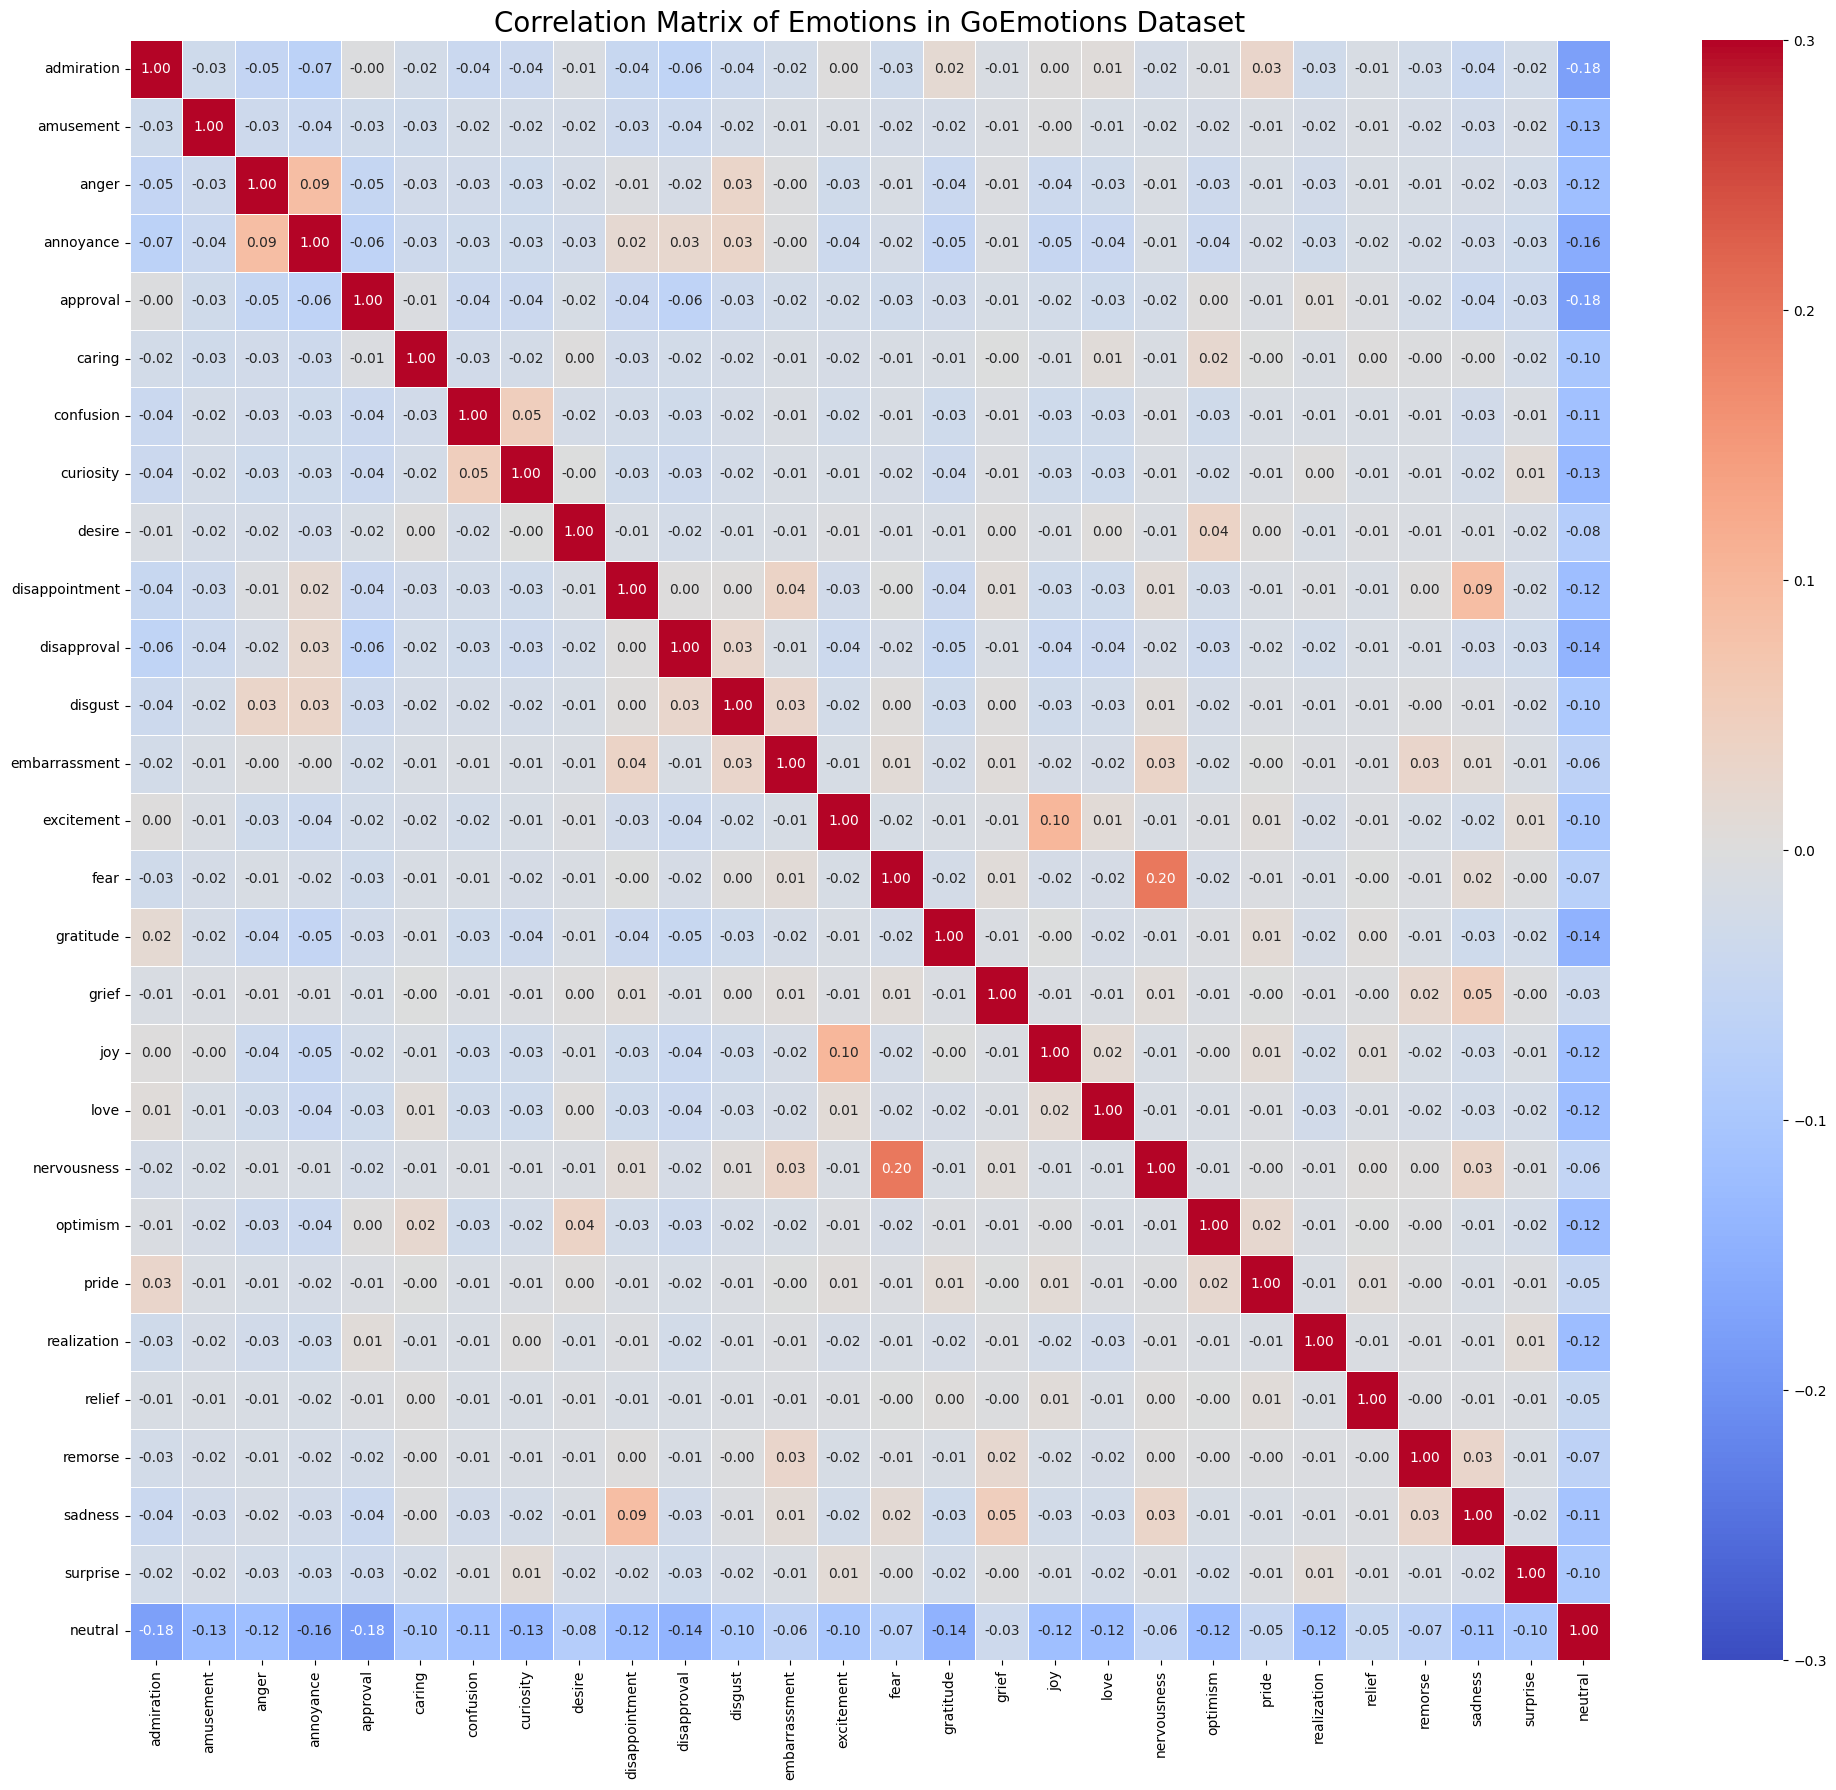

In [ ]:
# Correlations between different emotions.
def get_correlation_matrix(vmin=-0.3, vmax=0.3):
  """Calculates and visualizes the correlation matrix of emotions."""
  dfs = []
  for filename in os.listdir(FLAGS.data_dir):
    if filename.endswith(".csv"):
      dfs.append(
        pd.read_csv(os.path.join(FLAGS.data_dir, filename), encoding="utf-8"))
  df = pd.concat(dfs)

  # Identify the columns representing emotions.
  emotion_columns = df.columns[df.columns.get_loc('admiration'):]

  # Create a correlation matrix for the emotion columns
  correlation_matrix = df[emotion_columns].corr()

  # Create a heatmap to visualize the correlation matrix
  plt.figure(figsize=(20, 18))
  sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, vmin=vmin, vmax=vmax)
  plt.title('Correlation Matrix of Emotions in GoEmotions Dataset', fontsize=20)
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  plt.tight_layout()
  plt.savefig('goemotions_correlation_matrix.png')

  return correlation_matrix

# Correlationship flag for the data
correlation = FLAGS.correlation
print("Getting correlation matrix...")
empty_rels = [[0] * num_labels] * num_labels # construct placeholder for empty matrix
if correlation == 0: # if 0, don't bother making matrix
    corr_rels = empty_rels
else:
    corr_rels = get_correlation_matrix()

print(corr_rels)

The more red a value is, the higher the correlation. Where correlation is 1, the emotion is being correlated to itself.

There are several emotions that seem to have higher positive correlation values. Some examples are nervous and fear, at .2, excitement and joy at .1, and disappointment and sadness as well as annoyance and anger at .09. These means the emotions have a relationship to each other and tend to appear together.

There are also some negative correlations, where two emotions are likely to not occur together. Most of these larger results tend to be negative correlations with neutral which makes sense because neutral was meant to be labeled when there is an absence of emotion at all. For example, a text labelled as showing admiration is not likely to also be labeled as neutral; their correlation is -.18.

Outside of the neutral comparison, we have things like admiration and annoyance at -.07 which makes sense -- it can be difficult to express admiration and annoyance at the same time.

# Data loading
Most of this is from the original GoEmotions project, with modifications to fit the newer libraries and architecture changes. The below sections are all supporting code to load datasets into data structures supported by Tensorflow and turn it into tokens.

In [ ]:
# Custom class representing a single data example.
class InputExample(object):
  """A single training/test example for simple sequence classification."""

  def __init__(self, guid, text, labels=None):
    """Constructs a InputExample.

    Args:
      guid: Unique id for the example.
      text: string. The untokenized text of the input sequence.
      labels: (Optional) string. The labels of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
    self.guid = guid
    self.text = text
    self.labels = labels


In [ ]:
# Custom class for processing the dataset (the individual InputExamples)
class DataProcessor(object):
  """Class for preprocessing the corpus emotion dataset."""

  def __init__(self, num_labels, data_dir):
    self.num_labels = num_labels
    self.data_dir = data_dir

  # Gets list of InputExamples based on data from file
  def get_examples(self, data_type, fname):
    """Gets a collection of `InputExample`s for the train/dev/test set."""
    input_fname = os.path.join(self.data_dir, fname)
    return self._create_examples(
        self._read_df(input_fname, data_type), data_type)

  @classmethod
  def _read_df(cls, input_file, data_type):
    """Reads a tab separated value file."""
    sep = None
    if input_file.endswith("tsv"):
      sep = "\t"
    elif input_file.endswith("csv"):
      sep = ","
    elif data_type == "test":
      sep = "\t"
    else:
      print("Filetype not supported for %s" % input_file)
      return None

    if data_type == "test":
      names = ["text"]
    else:
      names = ["text", "labels"]

    # Load file
    print(input_file)
    return pd.read_csv(
        input_file,
        sep=sep,
        encoding="utf-8",
        header=None,
        names=names,
        usecols=names,
        dtype={"text": str})

  def _create_examples(self, df, data_type):
    """Creates examples for the training and dev sets."""
    examples = []
    for (i, row) in df.iterrows():
      guid = "%s-%s" % (data_type, i)
      labels = [0] * self.num_labels
      if isinstance(row["text"], float):
        text = ""  # This accounts for rare encoding errors
      else:
        text = row["text"]
      if data_type != "test":
        label_ids = str(row["labels"]).split(",")
        for idx in label_ids:
          labels[int(idx)] = 1
      examples.append(InputExample(guid=guid, text=text, labels=labels))
    return examples

# Actually call the data processing code
processor = DataProcessor(num_labels, FLAGS.data_dir)

In [ ]:
# Supporting functions needed to load the dataset in formats that Keras can deal with.

# Class to hold InputFeatures, from original GoEmotions code.
class InputFeatures(object):
  """A single set of features of data."""

  def __init__(self, input_ids, attention_mask, segment_ids, label_ids):
    self.input_ids = input_ids
    self.attention_mask = attention_mask
    self.segment_ids = segment_ids
    self.label_ids = label_ids

# This takes a single InputExample instance and convert it to InputFeatures.
# A variation of this existed in the GoEmotions code, but had to alter to work
# with Keras and the architecture.
def convert_single_example(ex_index, example, max_seq_length, tokenizer):
  """Converts a single `InputExample` into a single `InputFeatures`."""

  tokens = tokenizer.tokenize(example.text)
  # Account for [CLS] and [SEP] with "- 2"
  if len(tokens) > max_seq_length - 2:
    tokens = tokens[0:(max_seq_length - 2)]

  # As described in the original code, the convention in BERT is:
  # (a) For sequence pairs:
  #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
  #  type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
  # (b) For single sequences:
  #  tokens:   [CLS] the dog is hairy . [SEP]
  #  type_ids: 0     0   0   0  0     0 0
  #
  # Where "type_ids" are used to indicate whether this is the first
  # sequence or the second sequence.

  # Essentially, when it gets the token [CLS], BERT understands that as being
  # the start of the sentence, so this code needs to add the CLS token to the
  # beginning of what it pulled from the file. To mark the send, the sequence
  # "SEP] needs to be added.
  tokens = ["[CLS]"] + tokens + ["[SEP]"]
  segment_ids = [0] * len(tokens)

  input_ids = tokenizer.convert_tokens_to_ids(tokens)

  # The mask has 1 for real tokens and 0 for padding tokens. Only real
  # tokens are attended to.
  attention_mask = [1] * len(input_ids)

  # Zero-pad up to the sequence length to ensure equal length.
  while len(input_ids) < max_seq_length:
    input_ids.append(0)
    attention_mask.append(0)
    segment_ids.append(0)

  assert len(input_ids) == max_seq_length
  assert len(attention_mask) == max_seq_length
  assert len(segment_ids) == max_seq_length

  if ex_index < 5:
    logging.info("*** Example ***")
    logging.info("guid: %s" % (example.guid))
    logging.info("tokens: %s" %
                    " ".join(str(x) for x in tokens))
    logging.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
    logging.info("attention_mask: %s" % " ".join([str(x) for x in attention_mask]))
    logging.info("segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
    logging.info("labels: %s" % " ".join([str(x) for x in example.labels]))

  feature = InputFeatures(
      input_ids=input_ids,
      attention_mask=attention_mask,
      segment_ids=segment_ids,
      label_ids=example.labels)
  return feature

# This takes the InputExample classes pulled from the files and converts them to features.
def file_based_convert_examples_to_features(examples, max_seq_length, tokenizer,
                                            output_file):
  """Convert a set of `InputExample`s to a TFRecord file."""

  writer = tf.io.TFRecordWriter(output_file)

  for (ex_index, example) in enumerate(examples):
    if ex_index % 10000 == 0:
      logging.info("Writing example %d of %d" % (ex_index, len(examples)))

    feature = convert_single_example(ex_index, example, max_seq_length,
                                     tokenizer)

    def create_int_feature(values):
      f = tf.train.Feature(int64_list=tf.train.Int64List(value=list(values)))
      return f

    features = collections.OrderedDict()
    features["input_ids"] = create_int_feature(feature.input_ids)
    features["attention_mask"] = create_int_feature(feature.attention_mask)
    features["segment_ids"] = create_int_feature(feature.segment_ids)
    features["label_ids"] = create_int_feature(feature.label_ids)

    tf_example = tf.train.Example(features=tf.train.Features(feature=features))
    writer.write(tf_example.SerializeToString())
  writer.close()

# Create dataset from a TFRecord instance.
# This function is the biggest pain.
# The data we are using also contains segment_ids, but DistilBERT was not
# trained to support sentence-pair classification (which segment_ids) is
# used for, so that was removed.
def get_dataset(file_path, seq_length, batch_size, is_training,
                num_labels=None, drop_remainder=False, multilabel=False, include_labels=True):
    name_to_features = {
        "input_ids": tf.io.FixedLenFeature([seq_length], tf.int64),
        "attention_mask": tf.io.FixedLenFeature([seq_length], tf.int64),
    }

    if include_labels:
        if multilabel:
            name_to_features["label_ids"] = tf.io.VarLenFeature(tf.int64)
        else:
            name_to_features["label_ids"] = tf.io.FixedLenFeature([num_labels], tf.int64)

    def _decode_record(record):
        example = tf.io.parse_single_example(record, name_to_features)
        for name in list(example.keys()):
            t = example[name]
            if t.dtype == tf.int64:
                t = tf.cast(t, tf.int32)
            example[name] = t

        inputs = {
            "input_ids": example["input_ids"],
            "attention_mask": example["attention_mask"],
        }


        if include_labels:
            label_id = tf.cast(example["label_ids"], tf.float32)
            return inputs, label_id
        return inputs

    # make datasets work with the tf.nn loss functions
    def _preprocess(*args):
        if len(args) == 2:
            example, label = args
            label = tf.sparse.to_dense(label, default_value=0.0)
            return example, label
        else:
            example = args[0]
            return example

    dataset = tf.data.TFRecordDataset(file_path)
    if is_training:
        dataset = dataset.shuffle(1000).repeat()

    dataset = dataset.map(_decode_record)
    dataset = dataset.map(_preprocess)
    print(dataset)
    dataset = dataset.batch(batch_size, drop_remainder=drop_remainder)
    return dataset

# Classification layer
Custom layer used for handling classification instead of using the Keras default Dense layer. This includes a more fine-turned weight and bias mechanism based on the labels passed in.

In [ ]:
# Now time to start defining functions actually used to train the model.
# Custom Classifier Head
class CustomClassifierLayer(layers.Layer):
    def __init__(self, num_labels, hidden_size, **kwargs):
        super().__init__(**kwargs)
        self.num_labels = num_labels
        self.hidden_size = hidden_size

    # Adding a get_config() function to save and reload configurations on the layer
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_labels": self.num_labels,
            "hidden_size": self.hidden_size,
        })
        return config


    def build(self, input_shape):
        self.output_weights = self.add_weight(
            shape=(self.num_labels, self.hidden_size),
            initializer=initializers.TruncatedNormal(stddev=0.02),
            trainable=True,
            name="output_weights"
        )
        self.output_bias = self.add_weight(
            shape=(self.num_labels,),
            initializer='zeros',
            trainable=True,
            name="output_bias"
        )

    def call(self, inputs):
        logits = tf.matmul(inputs, self.output_weights, transpose_b=True)
        logits = tf.nn.bias_add(logits, self.output_bias)
        return logits

# The original code was written in Tensorflow 1 using the Estimators API, which has been deprecated
# and completely removed from the latest versions of Tensorflow. Since we are learning Keras in class,
# it seemed most logical to try to refactor the existing GoEmotions code as much as possible to use Keras.
# However, the Estimator API versus Keras API is extremely different, so it may not be a one-to-one replica of
# the original implementation.

# Loss function
Customized loss function that supporting regularalization and weights based on sentiment grouping, emotion correlation, and number of samples per label. The underlying algorithm (softmax or sigmoid) depends on whether multilabel processing is turned on. For the purpose of this project, we evaluated with multilabel processing only.

In [ ]:
# Custom loss function to reimplement the regularization of sentiment
# and correlation from the original code since it was implemented in the
# non-compatible Estimators API. Need to look through this more.
# If we can remove it, awesome.
class RegularizedClassificationLoss(losses.Loss):
    def __init__(self, class_weights, num_labels, multilabel, sentiment, sent_rels,
                 correlation, corr_rels, name="regularized_loss", **kwargs):
        super().__init__(name=name, **kwargs)
        self.class_weights = class_weights
        self.num_labels = num_labels
        self.multilabel = multilabel
        self.sentiment = sentiment
        self.correlation = correlation

        # --- Store weights and relationships ---
        # Store as numpy arrays for serialization and convert to TF constants for use in `call`.
        self._class_weights_np = np.array(class_weights, dtype=np.float32)
        self._sent_rels_np = np.array(sent_rels, dtype=np.float32)
        self._corr_rels_np = np.array(corr_rels, dtype=np.float32)

        self.class_weights_tf = tf.constant(self._class_weights_np, dtype=tf.float32)
        self.sent_rels = tf.constant(self._sent_rels_np, dtype=tf.float32)
        self.corr_rels = tf.constant(self._corr_rels_np, dtype=tf.float32)


    def get_config(self):
        """Allows the model to be saved and loaded by serializing the config."""
        config = super().get_config()
        config.update({
            "class_weights": self._class_weights_np.tolist(), # Convert to list for JSON
            "num_labels": self.num_labels,
            "multilabel": self.multilabel,
            "sentiment": self.sentiment,
            "sent_rels": self._sent_rels_np.tolist(),
            "correlation": self.correlation,
            "corr_rels": self._corr_rels_np.tolist()
        })
        return config

    @classmethod
    def from_config(cls, config):
        """Recreates the loss object from its config when loading a model."""
        return cls(**config)


    def call(self, y_true, logits):
        """Calculates the loss."""
        y_true = tf.cast(y_true, tf.float32)

        if self.multilabel:
            probs = tf.nn.sigmoid(logits)
            # Calculate the cross-entropy loss for each example and each class
            per_example_loss = tf.nn.sigmoid_cross_entropy_with_logits(
                labels=y_true, logits=logits)
        else:
            probs = tf.nn.softmax(logits, axis=-1)
            per_example_loss = tf.nn.softmax_cross_entropy_with_logits(
                labels=y_true, logits=logits)

        # --- Apply Class Weights ---
        # Multiply the loss for each class by its corresponding weight.
        # This is the core of the weighted loss implementation.
        weighted_loss = per_example_loss * self.class_weights_tf
        base_loss = tf.reduce_mean(weighted_loss)

        # --- Regularization Terms (Unchanged) ---
        # Ensure probs has shape [batch_size, num_labels]
        probs = tf.ensure_shape(probs, [None, self.num_labels])

        # Expand and tile probabilities for distance calculation
        probs_exp = tf.expand_dims(probs, 1)
        m = tf.tile(probs_exp, [1, self.num_labels, 1])
        probs_exp_t = tf.transpose(probs_exp, perm=[0, 2, 1])
        dists = tf.square(m - probs_exp_t)
        dists = tf.transpose(dists, perm=[0, 2, 1])

        # Sentiment regularization
        sent_reg = self.sentiment * tf.reduce_mean(dists * self.sent_rels)

        # Correlation regularization
        corr_reg = self.correlation * tf.reduce_mean(dists * self.corr_rels)

        # --- Final Loss ---
        total_loss = base_loss + sent_reg + corr_reg
        return total_loss


# F1 score for during model processing
This is a custom F1 score function to display F1 score while the model is being evaluated, giving us a rough idea of the performance before the training has completed. We use a custom F1-score calculation because for multi-label imbalance datasets, standard F1-score would not be able to give us the correct resilts.

In [ ]:
# Transformer models do not run with the keras.metrics F1_score function.
# Reimplementing F1 Score to use as a metric compatible with the transformer libraries.

class MultiLabelWeightedF1Score(metrics.Metric):
    def __init__(self, num_labels, threshold=0.5, name='weighted_f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_labels = num_labels
        self.threshold = threshold

        self.tp = self.add_weight(name='true_positives', shape=(num_labels,), initializer='zeros')
        self.fp = self.add_weight(name='false_positives', shape=(num_labels,), initializer='zeros')
        self.fn = self.add_weight(name='false_negatives', shape=(num_labels,), initializer='zeros')
        self.support = self.add_weight(name='support', shape=(num_labels,), initializer='zeros')  # For weighting

    # Adding a get_config() function to save and reload model
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_labels": self.num_labels,
            "threshold": self.threshold
        })
        return config

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.nn.sigmoid(y_pred)
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        tp = tf.reduce_sum(y_true * y_pred, axis=0)
        fp = tf.reduce_sum((1 - y_true) * y_pred, axis=0)
        fn = tf.reduce_sum(y_true * (1 - y_pred), axis=0)
        support = tf.reduce_sum(y_true, axis=0)

        self.tp.assign_add(tp)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)
        self.support.assign_add(support)

    def result(self):
        precision = self.tp / (self.tp + self.fp + 1e-7)
        recall = self.tp / (self.tp + self.fn + 1e-7)
        f1 = 2 * precision * recall / (precision + recall + 1e-7)

        weights = self.support / (tf.reduce_sum(self.support) + 1e-7)
        weighted_f1 = tf.reduce_sum(f1 * weights)
        return weighted_f1

    def reset_state(self):
        for var in [self.tp, self.fp, self.fn, self.support]:
            var.assign(tf.zeros_like(var))

# The below class is not needed
class F1MetricsCallback(callbacks.Callback):
    def __init__(self, eval_dataset, threshold=0.5):
        super().__init__()
        self.eval_dataset = eval_dataset
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        y_true_all = []
        y_pred_all = []

        for batch in self.eval_dataset:
            x_batch, y_true = batch
            y_pred = self.model.predict(x_batch, verbose=0)
            y_true_all.append(y_true.numpy())
            y_pred_all.append(y_pred)

        y_true_all = np.concatenate(y_true_all, axis=0)
        y_pred_all = np.concatenate(y_pred_all, axis=0)

        # Binarize predictions
        y_pred_bin = (y_pred_all > self.threshold).astype(int)

        micro = f1_score(y_true_all, y_pred_bin, average='micro')
        macro = f1_score(y_true_all, y_pred_bin, average='macro')
        per_class = f1_score(y_true_all, y_pred_bin, average=None)

        print(f"\nEpoch {epoch + 1} F1 Scores:")
        print(f" - Micro F1: {micro:.4f}")
        print(f" - Macro F1: {macro:.4f}")
        print(f" - Per-class F1: {np.round(per_class, 4)}")

# Learning rate schedule
Function to define custom learning rate schedule to be used by the AdamW optimizer. Warmup stabilizes the model during initial training, decay helps the model converge.

In [ ]:
# Custom learning_rate schedule that more closely aligns with original GoEmotions implementation.
class WarmUpAndDecaySchedule(optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr, num_warmup_steps, num_train_steps):
        super(WarmUpAndDecaySchedule, self).__init__()
        self.initial_lr = initial_lr
        self.num_warmup_steps = num_warmup_steps
        self.num_train_steps = num_train_steps

    def __call__(self, step):
        # Linear decay
        linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
            initial_learning_rate=self.initial_lr,
            decay_steps=self.num_train_steps,
            end_learning_rate=0.0,
            power=1.0
        )(step)

        # Linear warmup
        warmup_percent = tf.cast(step, tf.float32) / tf.cast(self.num_warmup_steps, tf.float32)
        warmup_lr = self.initial_lr * warmup_percent

        return tf.cond(
            step < self.num_warmup_steps,
            lambda: warmup_lr,
            lambda: linear_decay
        )

    # Add get_config method for serialization
    def get_config(self):
        return {
            "initial_lr": self.initial_lr,
            "num_warmup_steps": self.num_warmup_steps,
            "num_train_steps": self.num_train_steps,
        }

# Build model function
Function to actually build the model. This initialized the pre-trained DistilBERT model from HuggingFace, then our reimplementation of TextCNN from PyTorch to Tensorflow. After this we concentenate the two outputs, add some dropouts, and reimplement the final layers from GoEmotions where the custom classifier and loss functions using the AdamW optimizer with the custom learning rate schedule come into play.

In [ ]:
# Building the combined model
def build_combined_model(bert_config, seq_length, is_training,
                num_labels, init_checkpoint, multilabel,
                sent_rels, sentiment,
                corr_rels, correlation, idx2emotion,
                sentiment_groups, intensity_groups,
                num_train_steps, num_warmup_steps,
                vocab_size, embedding_dim):

    # --- DistilBERT Branch ---
    # Define inputs for DistilBERT
    input_ids = layers.Input(shape=(seq_length,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(seq_length,), dtype=tf.int32, name='attention_mask')
    inputs = [input_ids, attention_mask]

    # Instantiate the base TFDistilBertModel
    # Set HF_HOME environment variable before loading the model
    os.environ['HF_HOME'] = '/content/huggingface_cache'
    bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased', local_files_only=False, from_pt=True)

    # Get the last hidden state from the base DistilBERT model
    bert_output = bert_model(input_ids=input_ids, attention_mask=attention_mask)
    last_hidden_state = bert_output.last_hidden_state

    # Get the hidden state of the [CLS] token
    distilbert_features = last_hidden_state[:, 0, :]

    # --- TextCNN Branch ---
    # Input layer for TextCNN (same input_ids as DistilBERT)
    # We can reuse input_ids since both models process the sequence of token IDs.
    textcnn_input = input_ids

    # Embedding layer for TextCNN
    embedding_layer = Embedding(input_dim=vocab_size,
                                output_dim=embedding_dim,
                                input_length=seq_length)(textcnn_input)

    # Convolutional layers with different kernel sizes for TextCNN
    conv_blocks = []
    filter_sizes = [3, 4, 5] # Example kernel sizes
    num_filters = 128 # Example number of filters per kernel size

    for filter_size in filter_sizes:
        conv = Conv1D(filters=num_filters,
                      kernel_size=filter_size,
                      activation='relu')(embedding_layer)
        pool = GlobalMaxPooling1D()(conv)
        conv_blocks.append(pool)

    # Concatenate the pooled outputs from TextCNN
    if len(conv_blocks) > 1:
        textcnn_features = Concatenate()(conv_blocks)
    else:
        textcnn_features = conv_blocks[0]

    # Add dropout after TextCNN features
    textcnn_features = Dropout(0.4)(textcnn_features) # Added Dropout

    # --- Combine Features ---
    # Concatenate the features from DistilBERT and TextCNN
    combined_features = Concatenate()([distilbert_features, textcnn_features])

    # Add dropout for regularization on combined features
    dropout_layer = Dropout(0.5)(combined_features)

    # Instantiate CustomClassifierLayer
    hidden_size = dropout_layer.shape[-1] # Retrieving the size of features of the combined model
    classifier_layer = CustomClassifierLayer(num_labels=num_labels, hidden_size=hidden_size)

    # Pass the combined vector through the classifier layer for the output_layer
    output_layer = classifier_layer(dropout_layer) # replaced from logits

    # Create the combined model
    model = models.Model(inputs=inputs, outputs=output_layer)

    # Load weights from checkpoint (if applicable)
    if init_checkpoint:
        logging.info(f"Attempting to load weights from: {init_checkpoint}")
        try:
            model.load_weights(init_checkpoint)
            logging.info("Weights loaded successfully.")
        except Exception as e:
            logging.warning(f"Failed to load weights from {init_checkpoint}: {e}")
            logging.warning("Model will start with randomly initialized weights in the classification head.")


    # Instantiate custom loss function
    regularization_loss_func = RegularizedClassificationLoss(
        class_weights = class_weights,
        num_labels=num_labels,
        multilabel=multilabel,
        sentiment=sentiment,
        sent_rels=sent_rels,
        correlation=correlation,
        corr_rels=corr_rels
    )

    # Define metrics list
    if multilabel:
        metrics_list = [
            metrics.BinaryAccuracy(name='accuracy'),
            metrics.AUC(name='auc', multi_label=True),
            metrics.Precision(name='precision'),
            metrics.Recall(name='recall'),
            MultiLabelWeightedF1Score(num_labels=num_labels)
        ]
    else:
        metrics_list = [
            metrics.CategoricalAccuracy(name='accuracy'),
            metrics.AUC(name='auc'),
            metrics.Precision(name='precision'),
            metrics.Recall(name='recall')
        ]

    # Define learning rate schedule
    lr_schedule = WarmUpAndDecaySchedule(
        initial_lr=FLAGS.learning_rate,
        num_warmup_steps=num_warmup_steps,
        num_train_steps=num_train_steps
    )

    # Instantiate optimizer within the function (as a previous attempt to fix distribute_strategy error)
    optimizer = optimizers.AdamW(
        learning_rate=lr_schedule,
        clipnorm=1.0,
        weight_decay=0.01,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-6
    )


    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss=regularization_loss_func,  # Use the custom regularization loss
        metrics=metrics_list
    )

    print("Model built and compiled successfully!")
    return model

# Set-up for training model
Initiate variables and tokenizer, take data from flags and pass it into our functions to actually build the model and summarize its structure. Also load the train dataset.

In [ ]:
# Initialize variables used for actual model

train_examples = None

num_train_steps = None

num_warmup_steps = None

# Number of epochs used in DistilBERT model
num_train_epochs = int(FLAGS.num_train_epochs)

In [ ]:
# If we are training the model, load the datasets and output the params we are using for training
if FLAGS.do_train:
    # get the train and test datasets from DataProcessor.
    train_examples = processor.get_examples("train", FLAGS.train_fname)
    eval_examples = processor.get_examples("dev", FLAGS.dev_fname)

    # setting other variables needed for training
    num_eval_examples = len(eval_examples)
    num_train_steps = int(
        len(train_examples) / FLAGS.train_batch_size * FLAGS.num_train_epochs)
    num_warmup_steps = int(num_train_steps * FLAGS.warmup_proportion)

    # Collect all of the params being used.
    params = {
        "num_labels": num_labels,
        "learning_rate": FLAGS.learning_rate,
        "num_train_epochs": num_train_epochs,
        "warmup_proportion": FLAGS.warmup_proportion,
        "sentiment": FLAGS.sentiment,
        "correlations": FLAGS.correlation,
        "batch_size": FLAGS.train_batch_size,
        "num_train_examples": len(train_examples),
        "num_eval_examples": num_eval_examples,
        "data_dir": FLAGS.data_dir,
        "output_dir": FLAGS.output_dir,
        "train_fname": FLAGS.train_fname,
        "dev_fname": FLAGS.dev_fname,
        "test_fname": FLAGS.test_fname
    }

    # Write the params and their values to a file and put it in the output directory
    with open(os.path.join(FLAGS.output_dir, "config.json"), "w") as f:
      json.dump(params, f)

/content/train.tsv
/content/dev.tsv


In [ ]:
# Original code has a flag to choose whether you are doing cased or uncased, so to simulate that
# behavior with DistilBERT, allowing the option to switch the tokenizer used.
if FLAGS.do_lower_case:
    tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased', return_tensors="tf")
else:
    tokenizer = AutoTokenizer.from_pretrained('distilbert-base-cased', return_tensors="tf")

# As per huggingface, we should use the AutoTokenizer

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Now that we have the params and model object, load the datasets for training
if FLAGS.do_train:
    train_file = os.path.join(FLAGS.output_dir, "train.tf_record")
    file_based_convert_examples_to_features(train_examples,
                                            FLAGS.max_seq_length, tokenizer,
                                            train_file)
    eval_file = os.path.join(FLAGS.output_dir, "eval.tf_record")
    file_based_convert_examples_to_features(eval_examples, FLAGS.max_seq_length,
                                            tokenizer, eval_file)

    logging.info("***** Running training and evaluation *****")
    logging.info("  Num train examples = %d", len(train_examples))
    logging.info("  Num eval examples = %d", num_eval_examples)
    logging.info("  Batch size = %d", FLAGS.train_batch_size)
    logging.info("  Num training steps = %d", num_train_steps)


    train_dataset = get_dataset(
        file_path=train_file,
        seq_length=FLAGS.max_seq_length,
        batch_size=FLAGS.train_batch_size,
        is_training=True,
        num_labels=num_labels,
        drop_remainder=True,
        multilabel=FLAGS.multilabel,
        include_labels=True
    )

    # train_batch_size is the correct parameter here,
    # the original code did it too.
    eval_dataset = get_dataset(
        file_path=eval_file,
        seq_length=FLAGS.max_seq_length,
        batch_size=FLAGS.train_batch_size,
        is_training=False,
        num_labels=num_labels,
        drop_remainder=False,
        multilabel=FLAGS.multilabel,
        include_labels=True
    )

<_MapDataset element_spec=({'input_ids': TensorSpec(shape=(50,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(50,), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.float32, name=None))>
<_MapDataset element_spec=({'input_ids': TensorSpec(shape=(50,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(50,), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the mode

Model built and compiled successfully!
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 50)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 50, 100)              3052200   ['input_ids[0][0]']           
                                                                                                  
 conv1d (Conv1D)             (None, 48, 128)              38528     ['embedding[0][0]']           
                                                                                                  
 conv1d_1 (Conv1D)           (None, 47, 128)              51328     ['embedding[0][0]']           
                                                       

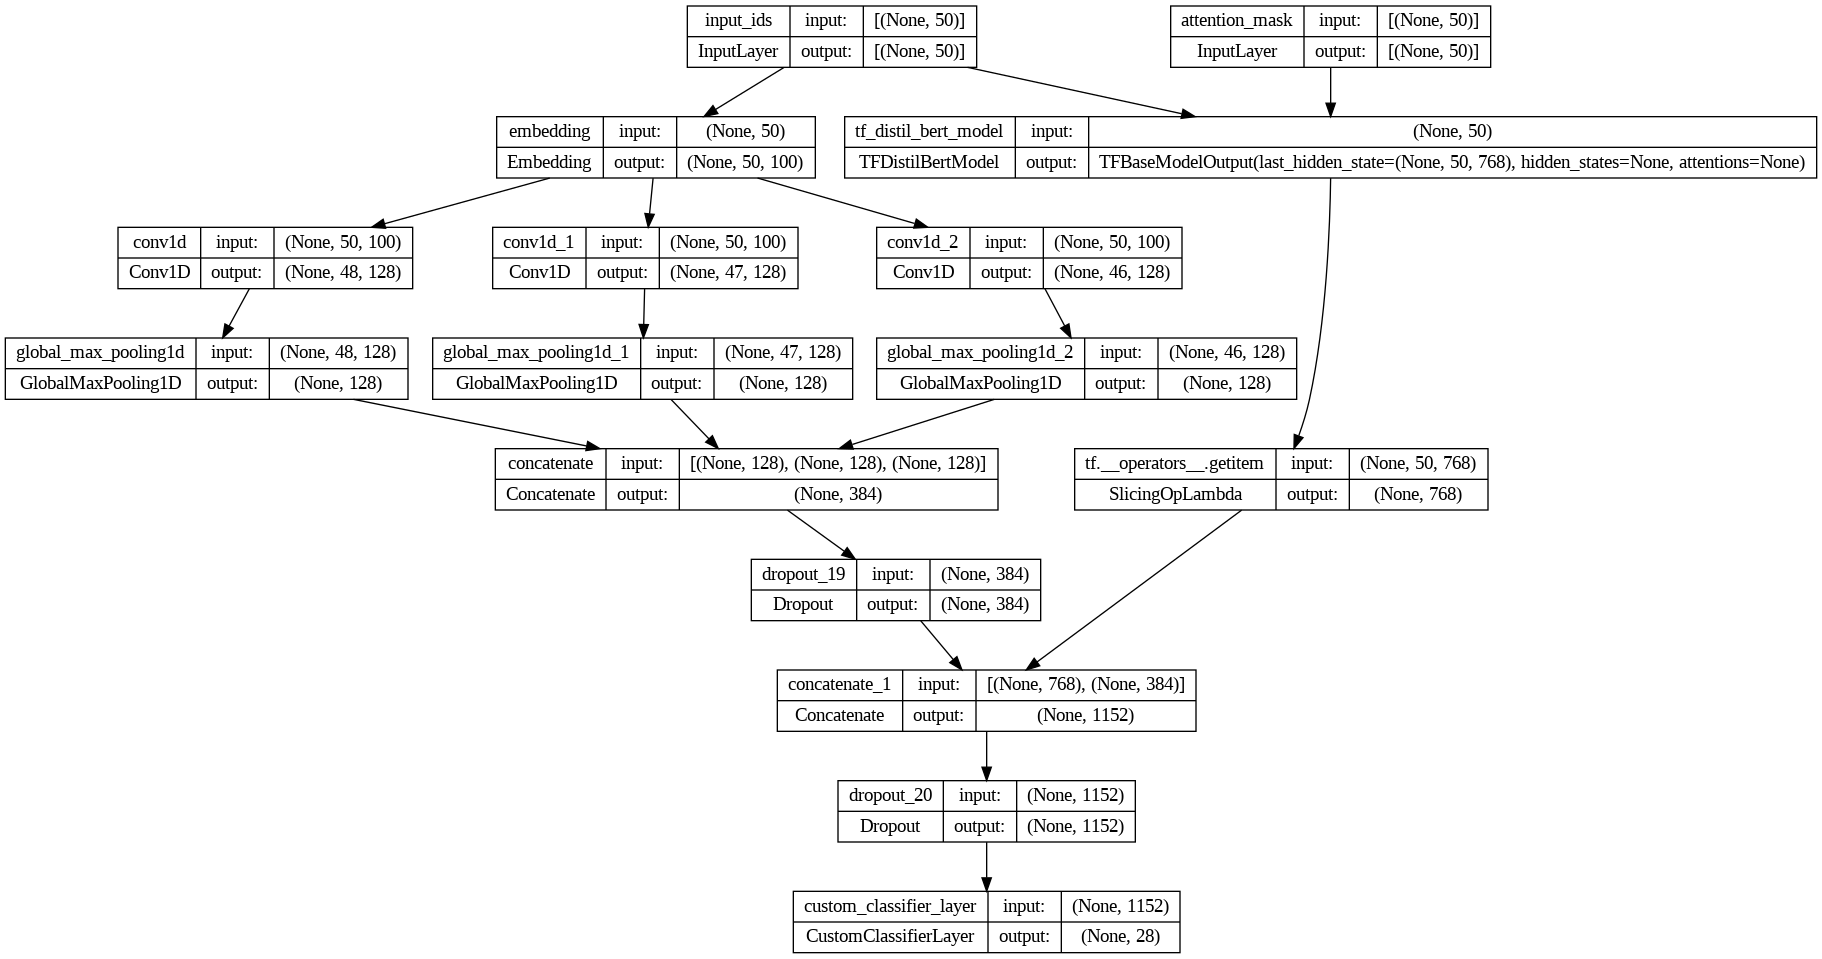

In [ ]:
# Instantiate the combined model
vocab_size = len(tokenizer.vocab)
embedding_dim = FLAGS.embedding_dim # Embedding dimension for TextCNN
max_seq_length = FLAGS.max_seq_length
num_labels = num_labels

combined_model = build_combined_model(
    bert_config=None, # Not directly used
    seq_length=max_seq_length,
    is_training=True, # Set to True for training
    num_labels=num_labels,
    init_checkpoint=None,
    multilabel=FLAGS.multilabel,
    sent_rels=sent_rels, # Pass the actual sent_rels matrix
    sentiment=FLAGS.sentiment,
    corr_rels=corr_rels, # Pass the actual corr_rels matrix
    correlation=FLAGS.correlation,
    idx2emotion=idx2emotion,
    sentiment_groups=None, # Currently not used in model build
    intensity_groups=None, # Currently not used in model build
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    vocab_size=vocab_size,
    embedding_dim=embedding_dim
)

# Display the model summary
combined_model.summary()
tf.keras.utils.plot_model(combined_model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

The above demonstrates the layout of the model. The model essentially inputs the same data down two separate paths. On the left is the TextCNN arm of processing, on the right is the DistilBERT path. Ultimately, the two get concatenated together, passed through a dropout label, and run through our classifer code.

# Perform model training
Includes early stopping mechanism to stop training early if metrics show no reason to continue.

In [ ]:
# Train the model

# Calculate steps per epoch for training and evaluation
steps_per_epoch = num_train_steps // FLAGS.num_train_epochs
validation_steps = num_eval_examples // FLAGS.train_batch_size # Or adjust based on your needs

# Define Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', # Metric to monitor (e.g., validation loss)
    patience=4,        # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored metric
)


history = combined_model.fit(
    train_dataset,
    epochs= FLAGS.num_train_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=eval_dataset,
    validation_steps=validation_steps,
    callbacks=[early_stopping] # Add the early stopping callback
)

print("Training finished.")

Epoch 1/20
2713/2713 [==============================] - 189s 58ms/step - loss: 0.3029 - accuracy: 0.9517 - auc: 0.5099 - precision: 0.3382 - recall: 0.1546 - weighted_f1_score: 0.1814 - val_loss: 0.1168 - val_accuracy: 0.9584 - val_auc: 0.5838 - val_precision: 0.5065 - val_recall: 0.3750 - val_weighted_f1_score: 0.3114
Epoch 2/20
2713/2713 [==============================] - 119s 44ms/step - loss: 0.0981 - accuracy: 0.9639 - auc: 0.6373 - precision: 0.5986 - recall: 0.4310 - weighted_f1_score: 0.4557 - val_loss: 0.0850 - val_accuracy: 0.9677 - val_auc: 0.6834 - val_precision: 0.6601 - val_recall: 0.4744 - val_weighted_f1_score: 0.5315
Epoch 3/20
2713/2713 [==============================] - 116s 43ms/step - loss: 0.0753 - accuracy: 0.9682 - auc: 0.7125 - precision: 0.6519 - recall: 0.5212 - weighted_f1_score: 0.5687 - val_loss: 0.0818 - val_accuracy: 0.9681 - val_auc: 0.7313 - val_precision: 0.6464 - val_recall: 0.5304 - val_weighted_f1_score: 0.5783
Epoch 4/20
2713/2713 [===============

The model decided to stop training after 7 epochs, showing it was not seeing any additional improvements with more epochs.

## Validation

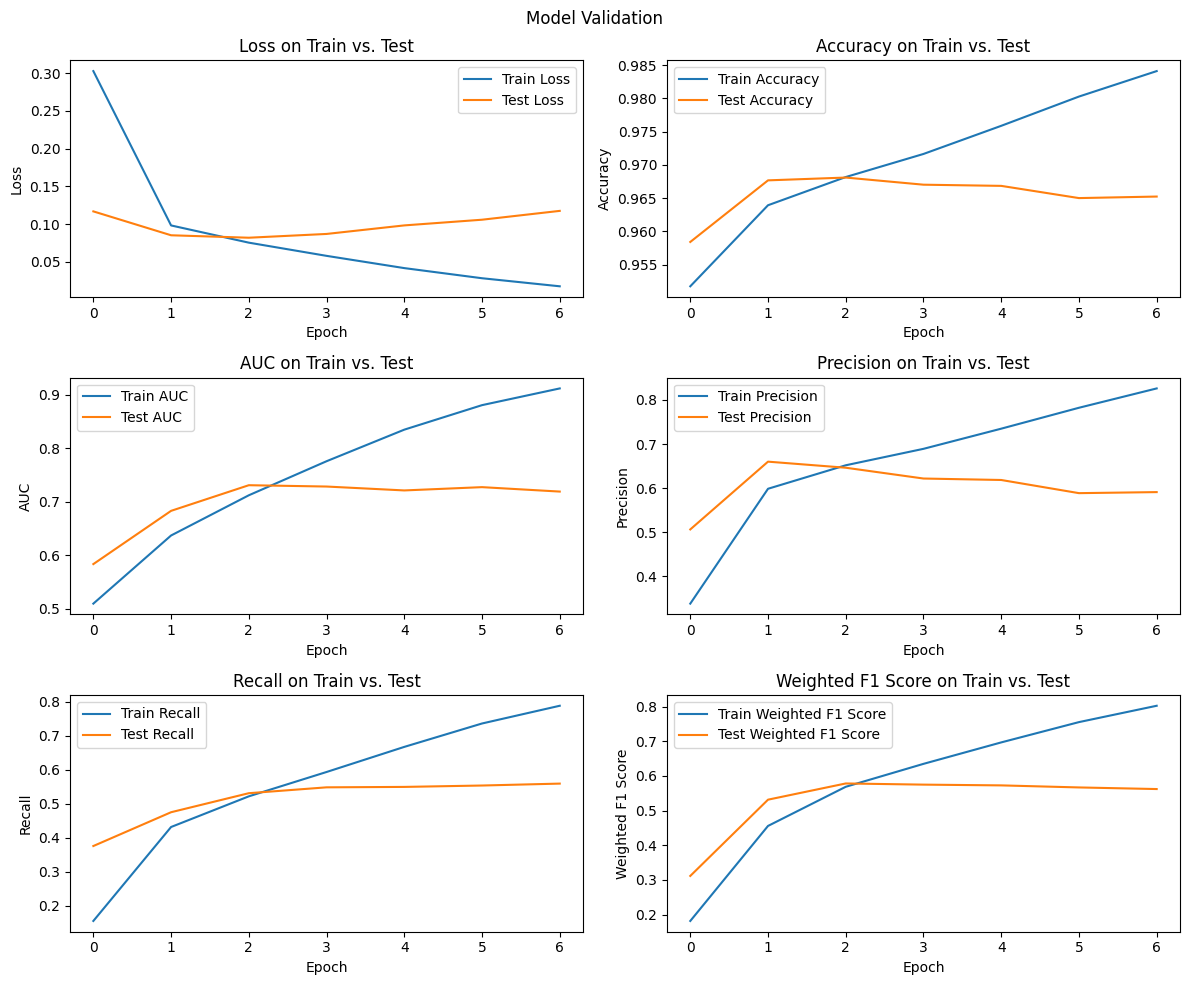

<Figure size 640x480 with 0 Axes>

In [ ]:
validation_fig, axs0 = plt.subplots(3, 2, figsize=(12, 10))
axs0[0, 0].plot(history.history['loss'], label='Train Loss')
axs0[0, 0].plot(history.history['val_loss'], label='Test Loss')
axs0[0, 0].set_xlabel('Epoch')
axs0[0, 0].set_ylabel('Loss')
axs0[0, 0].legend()
axs0[0, 0].set_title("Loss on Train vs. Test")

axs0[0, 1].plot(history.history['accuracy'], label='Train Accuracy')
axs0[0, 1].plot(history.history['val_accuracy'], label='Test Accuracy')
axs0[0, 1].set_xlabel('Epoch')
axs0[0, 1].set_ylabel('Accuracy')
axs0[0, 1].legend()
axs0[0, 1].set_title("Accuracy on Train vs. Test")

axs0[1, 0].plot(history.history['auc'], label='Train AUC')
axs0[1, 0].plot(history.history['val_auc'], label='Test AUC')
axs0[1, 0].set_xlabel('Epoch')
axs0[1, 0].set_ylabel('AUC')
axs0[1, 0].legend()
axs0[1, 0].set_title("AUC on Train vs. Test")

axs0[1, 1].plot(history.history['precision'], label='Train Precision')
axs0[1, 1].plot(history.history['val_precision'], label='Test Precision')
axs0[1, 1].set_xlabel('Epoch')
axs0[1, 1].set_ylabel('Precision')
axs0[1, 1].legend()
axs0[1, 1].set_title("Precision on Train vs. Test")

axs0[2, 0].plot(history.history['recall'], label='Train Recall')
axs0[2, 0].plot(history.history['val_recall'], label='Test Recall')
axs0[2, 0].set_xlabel('Epoch')
axs0[2, 0].set_ylabel('Recall')
axs0[2, 0].legend()
axs0[2, 0].set_title("Recall on Train vs. Test")

axs0[2, 1].plot(history.history['weighted_f1_score'], label='Train Weighted F1 Score')
axs0[2, 1].plot(history.history['val_weighted_f1_score'], label='Test Weighted F1 Score')
axs0[2, 1].set_xlabel('Epoch')
axs0[2, 1].set_ylabel('Weighted F1 Score')
axs0[2, 1].legend()
axs0[2, 1].set_title("Weighted F1 Score on Train vs. Test")

validation_fig.suptitle("Model Validation")
plt.tight_layout()
plt.show()
plt.savefig('model_validation.png')

# Save model

In [ ]:
# Save the trained model
model_save_path = os.path.join(FLAGS.output_dir, "combined_emotion_model")
combined_model.save(model_save_path +'/combined_model.h5')

print(f"Model saved to: {model_save_path}")

# Save the tokenizer as well for future test on same model
tokenizer.save_pretrained(model_save_path)
print(f"Tokenizer saved to: {model_save_path}")

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to: /content/output/combined_emotion_model
Tokenizer saved to: /content/output/combined_emotion_model


# Run predictions

In [ ]:
if FLAGS.do_predict:
    predict_examples = processor.get_examples("test", FLAGS.test_fname)
    num_actual_predict_examples = len(predict_examples)

    # Convert examples to TFRecord file
    predict_file = os.path.join(FLAGS.output_dir, "test.tf_record")
    file_based_convert_examples_to_features(
        predict_examples,
        FLAGS.max_seq_length,
        tokenizer,
        predict_file
    )


    logging.info("***** Running prediction *****")
    logging.info("  Num examples = %d (%d actual, %d padding)",
                 len(predict_examples), num_actual_predict_examples,
                 len(predict_examples) - num_actual_predict_examples)
    logging.info("  Batch size = %d", FLAGS.train_batch_size)

    # Load dataset from TFRecord
    predict_dataset = get_dataset(
        file_path=predict_file,
        seq_length=FLAGS.max_seq_length,
        batch_size=FLAGS.train_batch_size,
        num_labels=num_labels,
        is_training=False,
        drop_remainder=False,
        multilabel=FLAGS.multilabel,
        include_labels=False
    )



/content/test.tsv
<_MapDataset element_spec={'input_ids': TensorSpec(shape=(50,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(50,), dtype=tf.int32, name=None)}>


In [ ]:
if FLAGS.do_predict:
    # Run prediction with Keras model
    result = combined_model.predict(predict_dataset)

    output_predict_file = os.path.join(FLAGS.output_dir,
                                       FLAGS.test_fname + ".predictions.tsv")
    output_labels = os.path.join(FLAGS.output_dir,
                                 FLAGS.test_fname + ".label_predictions.tsv")


    # Write prediction probabilities to a file
    with tf.io.gfile.GFile(output_predict_file, "w") as writer:
        # Write header if needed (e.g., emotion names)
        # writer.write("\t".join(all_emotions) + "\n")
        for probabilities in result:
            writer.write("\t".join([str(p) for p in probabilities]) + "\n")

    # Write predicted labels to a file (based on a threshold, e.g., 0.5)
    with tf.io.gfile.GFile(output_labels, "w") as writer:
        # Write header if needed
        # writer.write("\t".join(all_emotions) + "\n")
        predicted_labels = (result > 0.5).astype(int) # Apply threshold
        for labels in predicted_labels:
             # Join labels with comma if multilabel, or just write the index if single label
             if FLAGS.multilabel:
                # Get indices of predicted labels that are 1
                predicted_indices = [str(i) for i, label in enumerate(labels) if label == 1]
                writer.write(",".join(predicted_indices) + "\n")
             else:
                # For single label, find the index with the highest probability
                predicted_index = np.argmax(labels)
                writer.write(str(predicted_index) + "\n")

    logging.info("Prediction results and labels written to files.")

340/340 [==============================] - 7s 14ms/step


In [ ]:
# Define the path to the test file and predicted labels file
test_file_path = FLAGS.test_fname
predicted_labels_file_path = output_labels
output_results_file = '/content/output/evaluation_results.txt' # Define the output file path

# 1. Load the true labels from the test file
try:
    # Read the test file
    test_df = pd.read_csv(test_file_path, sep='\t', header=None, names=['text', 'labels'],
                          usecols = ['text', 'labels'], dtype={'text': str})

    # Convert comma-separated label indices to a list of integers for each example
    true_labels_list = []
    for index, row in test_df.iterrows():
        # cases where there are no labels or missing labels
        if pd.isna(row['labels']):
            true_labels_list.append([])
        else:
            true_labels_list.append([int(idx) for idx in str(row['labels']).split(',') if idx.isdigit()])

    # Convert the list of label indices into a multilabel indicator matrix
    true_labels_matrix = np.zeros((len(true_labels_list), num_labels))
    for i, labels in enumerate(true_labels_list):
        for label_idx in labels:
            if 0 <= label_idx < num_labels: # Ensure label index is within bounds
                 true_labels_matrix[i, label_idx] = 1

    print(f"Loaded {len(true_labels_matrix)} true labels.")

except FileNotFoundError:
    print(f"Error: True labels file not found at {test_file_path}")
    true_labels_matrix = None
except Exception as e:
    print(f"Error loading true labels: {e}")
    true_labels_matrix = None



Loaded 5427 true labels.


In [ ]:

# 2. Load the predicted labels from the prediction file
try:
    predicted_labels_list = []
    with open(predicted_labels_file_path, 'r') as f:
        for line in f:
            line = line.strip() # Remove leading/trailing whitespace
            if line: # Check if the line is not empty
                # Split by comma and convert to integers, handling potential non-digit entries
                predicted_indices = [int(idx) for idx in line.split(',') if idx.isdigit()]
                predicted_labels_list.append(predicted_indices)
            else:
                # Handle empty lines for examples with no predicted labels
                predicted_labels_list.append([])


    # Convert the list of label indices into a multilabel indicator matrix
    # Ensuring the number of predicted examples match the number of true examples
    if true_labels_matrix is not None and len(predicted_labels_list) != len(true_labels_matrix):
        print(f"Warning: Number of predicted examples ({len(predicted_labels_list)}) does not match number of true examples ({len(true_labels_matrix)}). Evaluation may be inaccurate.")
        min_examples = min(len(predicted_labels_list), len(true_labels_matrix))
        predicted_labels_list = predicted_labels_list[:min_examples]


    predicted_labels_matrix = np.zeros((len(predicted_labels_list), num_labels))
    for i, labels in enumerate(predicted_labels_list):
        for label_idx in labels:
            if 0 <= label_idx < num_labels: # Check for label index within bounds
                predicted_labels_matrix[i, label_idx] = 1

    print(f"Loaded {len(predicted_labels_matrix)} predicted labels.")

except FileNotFoundError:
    print(f"Error: Predicted labels file not found at {predicted_labels_file_path}")
    predicted_labels_matrix = None
except Exception as e:
    print(f"Error loading predicted labels: {e}")
    predicted_labels_matrix = None


Loaded 5427 predicted labels.


In [ ]:
# 3. Calculate and Display Jaccard Score (Jaccard Similarity)

from sklearn.metrics import jaccard_score

# Calculate the Jaccard score averaged across all examples
# 'samples' average calculates the mean of the Jaccard score for each sample.
# 'macro' average calculates the Jaccard score for each label and finds their unweighted mean.
# 'weighted' average calculates the Jaccard score for each label and finds their average weighted by support (number of true instances for each label).

# Let's calculate and display the 'samples' average and 'weighted' average as they are common for multi-label.
jaccard_samples_avg = jaccard_score(true_labels_matrix, predicted_labels_matrix, average='samples')
jaccard_weighted_avg = jaccard_score(true_labels_matrix, predicted_labels_matrix, average='weighted')
jaccard_macro_avg = jaccard_score(true_labels_matrix, predicted_labels_matrix, average='macro', zero_division=0)


print("\nCalculating Jaccard Score:")
print(f"Jaccard Score (Samples Average): {jaccard_samples_avg:.4f}")
print(f"Jaccard Score (Weighted Average): {jaccard_weighted_avg:.4f}")
print(f"Jaccard Score (Macro Average): {jaccard_macro_avg:.4f}")


Calculating Jaccard Score:
Jaccard Score (Samples Average): 0.5195
Jaccard Score (Weighted Average): 0.4110
Jaccard Score (Macro Average): 0.3358


**Analysis:**
1. Jaccard Score (Samples Average): This is the average Jaccard score calculated for each individual instance (sample) in the dataset. It gives an idea of the average overlap between true and predicted labels at the instance level. The output shows Jaccard Score (Samples Average): 0.5195. This means, on average, about 51.95% of the combined set of true and predicted labels for each instance were correctly predicted.
2. Jaccard Score (Weighted Average): This calculates the Jaccard score for each individual label (emotion) and then takes the average, weighted by the support (the number of true instances for each label). This is useful if we wish to account for class imbalance and see a metric that reflects performance on more frequent classes. The output shows Jaccard Score (Weighted Average): 0.4110. This is a bit lower than the samples average, suggesting that while individual instances might have a reasonable overlap, the performance when weighted by the frequency of each emotion is slightly lower.
3. Jaccard Score (Macro Average): This calculates the Jaccard score for each individual label (emotion) and then takes the unweighted average. This metric treats all labels equally, regardless of how many times they appear in the dataset. It can highlight performance on less frequent classes. The output shows Jaccard Score (Macro Average): 0.3358. This is the lowest of the three, which is common in datasets with class imbalance. It suggests that when considering the model's ability to correctly identify each emotion equally, the performance is lower, likely due to the difficulty in predicting less frequent emotions.

# Classification Report

In [ ]:
# 4. Display Classification Report

from sklearn.metrics import classification_report
import os

output_report_file = os.path.join(FLAGS.output_dir, "classification_report.txt")

# Generate the classification report
# We need to provide target_names for the emotion labels
target_names = [idx2emotion.get(i, f"Label {i}") for i in range(num_labels)]

report = classification_report(true_labels_matrix, predicted_labels_matrix, target_names=target_names, zero_division=0)

print("\nClassification Report:")
# Print the report to the console
print(report)

# Write the report to a file
with open(output_report_file, 'w') as f:
    f.write("Classification Report:\n\n")
    f.write(report)

print(f"\nClassification report also saved to {output_report_file}")


Classification Report:
                precision    recall  f1-score   support

    admiration       0.69      0.62      0.65       504
     amusement       0.82      0.77      0.80       264
         anger       0.61      0.35      0.45       198
     annoyance       0.48      0.12      0.20       320
      approval       0.61      0.17      0.26       351
        caring       0.59      0.26      0.36       135
     confusion       0.45      0.42      0.44       153
     curiosity       0.44      0.75      0.55       284
        desire       0.56      0.17      0.26        83
disappointment       0.38      0.19      0.25       151
   disapproval       0.43      0.27      0.33       267
       disgust       0.66      0.42      0.51       123
 embarrassment       0.83      0.27      0.41        37
    excitement       0.53      0.31      0.39       103
          fear       0.65      0.65      0.65        78
     gratitude       0.98      0.85      0.91       352
         grief       1.

This shows the results of the attempts at doing multilabel classification. Across all categories, we got a macro-label F1 score of .48, which exceeds the GoEmotions value of .46. F1 Score is the most important metric when it comes to evaluating the performance of multilabel classification problems.

As for precision, we got an overall macro of .61, which exceeds GoEmotions' precision of .40 For recall, we got a macro of .42, which is less than GoEmotions' recall of .63. Overall, we have better precision, but poorer recall. Which metric is more important does depend on the use-case; for the use-case of sentiment analysis for AI therapy that we discussed, precision scores are more important than recall, so we consider our model an improvement.

The per-label values are also very important to analyze to determine model performance. The best performing categories based on F1 score were gratitude, amusement, love, grief and admiration.

The lower performers, also based on F1 score, were relief, annoyance, nervousness, and realization. One possible reason for lower scores in categories like nervousness, embarrassment, and relief specifically are because of low amounts of data.

We do observe some trade-offs:  "curiosity" has high recall but lower
precision, while "disappointment" has high precision but low recall.

The "neutral" emotion has a moderate F1-score, with decent
number of False Negatives suggesting failure to identify neutral
instances.

# Confusion Matrix


Calculating Per-Class Confusion Matrices and generating heatmaps:
Rows are True Labels, Columns are Predicted Labels


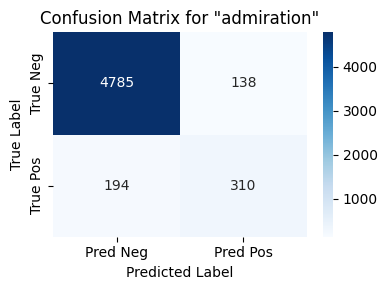

Confusion matrix for 'admiration' saved as 'confusion_matrix_admiration.png'



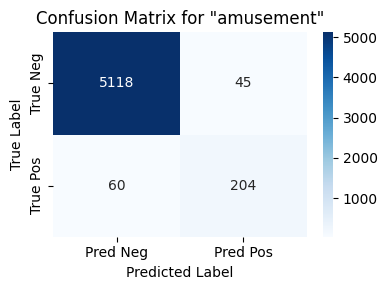

Confusion matrix for 'amusement' saved as 'confusion_matrix_amusement.png'



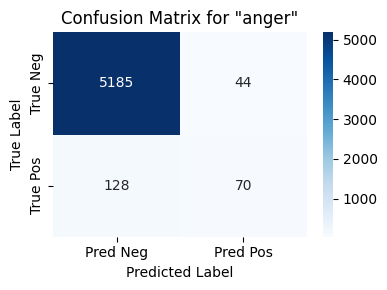

Confusion matrix for 'anger' saved as 'confusion_matrix_anger.png'



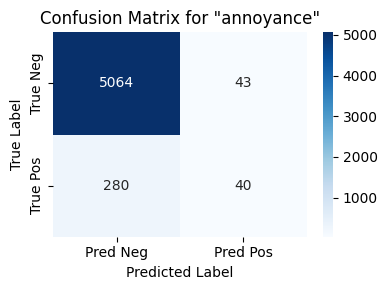

Confusion matrix for 'annoyance' saved as 'confusion_matrix_annoyance.png'



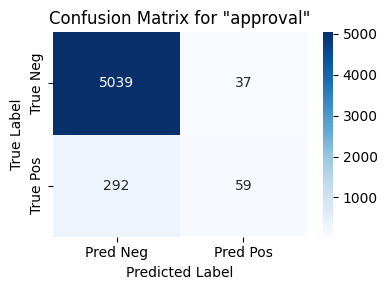

Confusion matrix for 'approval' saved as 'confusion_matrix_approval.png'



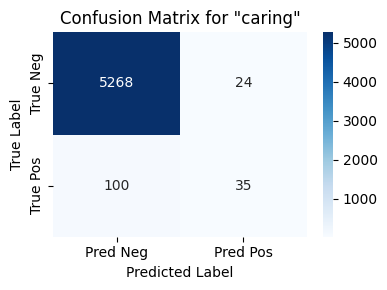

Confusion matrix for 'caring' saved as 'confusion_matrix_caring.png'



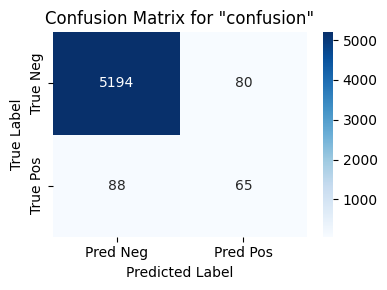

Confusion matrix for 'confusion' saved as 'confusion_matrix_confusion.png'



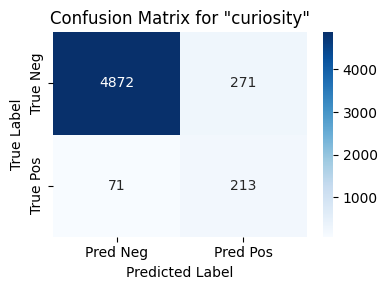

Confusion matrix for 'curiosity' saved as 'confusion_matrix_curiosity.png'



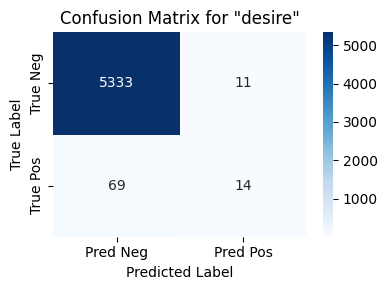

Confusion matrix for 'desire' saved as 'confusion_matrix_desire.png'



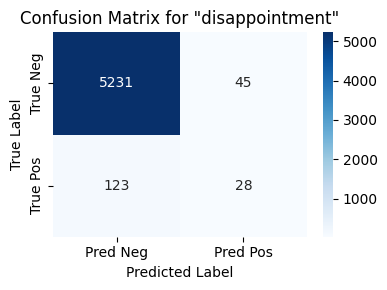

Confusion matrix for 'disappointment' saved as 'confusion_matrix_disappointment.png'



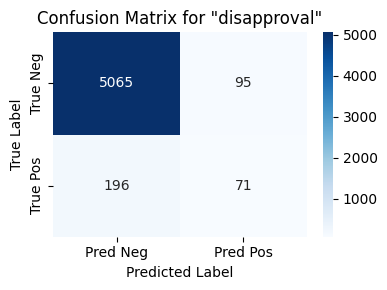

Confusion matrix for 'disapproval' saved as 'confusion_matrix_disapproval.png'



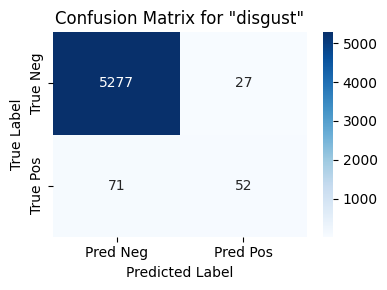

Confusion matrix for 'disgust' saved as 'confusion_matrix_disgust.png'



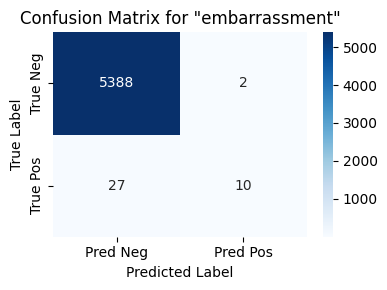

Confusion matrix for 'embarrassment' saved as 'confusion_matrix_embarrassment.png'



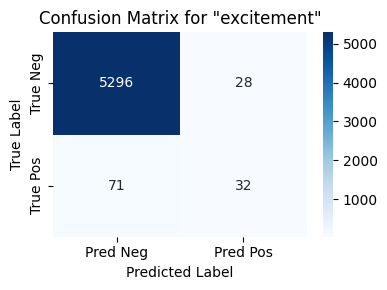

Confusion matrix for 'excitement' saved as 'confusion_matrix_excitement.png'



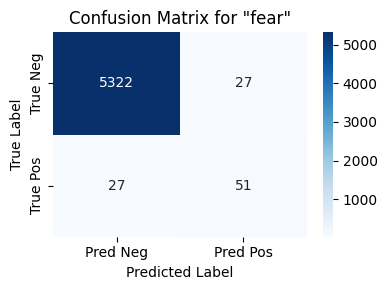

Confusion matrix for 'fear' saved as 'confusion_matrix_fear.png'



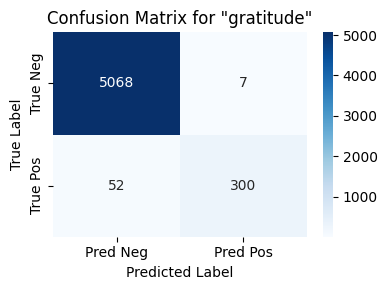

Confusion matrix for 'gratitude' saved as 'confusion_matrix_gratitude.png'



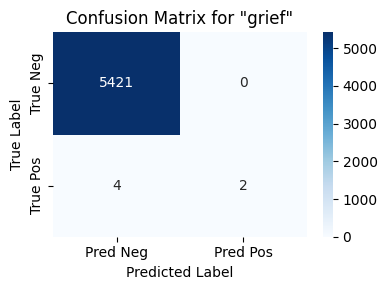

Confusion matrix for 'grief' saved as 'confusion_matrix_grief.png'



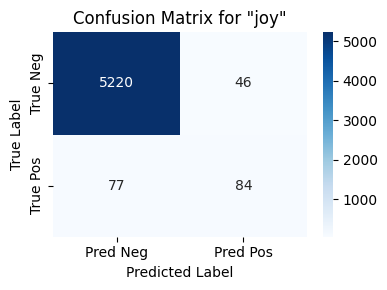

Confusion matrix for 'joy' saved as 'confusion_matrix_joy.png'



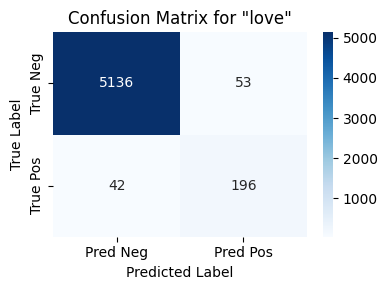

Confusion matrix for 'love' saved as 'confusion_matrix_love.png'



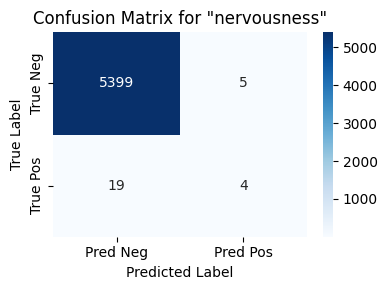

Confusion matrix for 'nervousness' saved as 'confusion_matrix_nervousness.png'



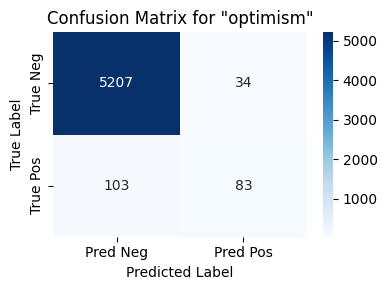

Confusion matrix for 'optimism' saved as 'confusion_matrix_optimism.png'



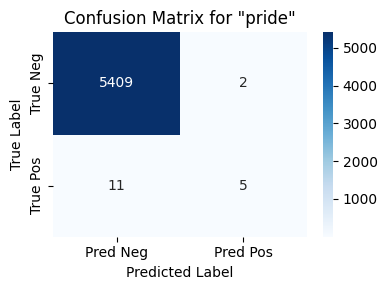

Confusion matrix for 'pride' saved as 'confusion_matrix_pride.png'



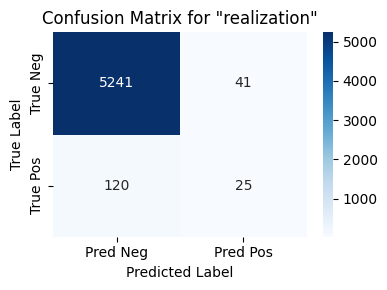

Confusion matrix for 'realization' saved as 'confusion_matrix_realization.png'



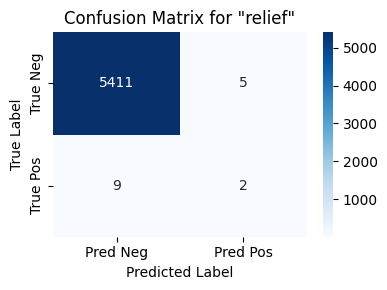

Confusion matrix for 'relief' saved as 'confusion_matrix_relief.png'



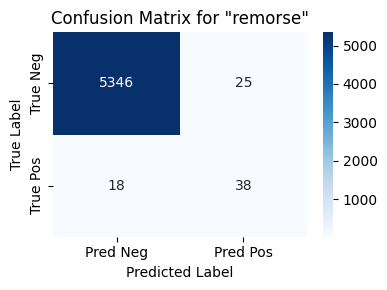

Confusion matrix for 'remorse' saved as 'confusion_matrix_remorse.png'



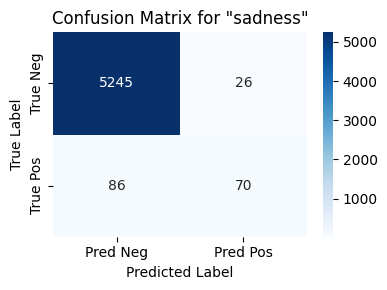

Confusion matrix for 'sadness' saved as 'confusion_matrix_sadness.png'



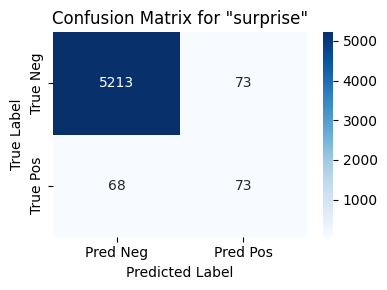

Confusion matrix for 'surprise' saved as 'confusion_matrix_surprise.png'



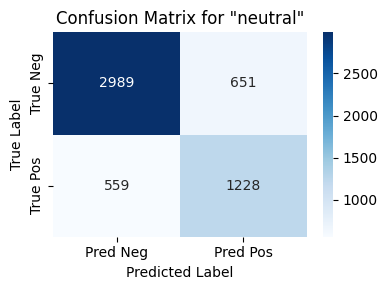

Confusion matrix for 'neutral' saved as 'confusion_matrix_neutral.png'



In [ ]:
# 5. Calculate and Display Confusion Matrix (per class)

print("\nCalculating Per-Class Confusion Matrices and generating heatmaps:")
print("Rows are True Labels, Columns are Predicted Labels")

# Iterate through each emotion class
for i in range(num_labels):
    emotion_name = idx2emotion.get(i, f"Label {i}")

    # Get true and predicted labels for the current class
    y_true_class = true_labels_matrix[:, i]
    y_pred_class = predicted_labels_matrix[:, i]

    # Calculate confusion matrix for the current class
    # The matrix will be [[TN, FP], [FN, TP]]
    cm = confusion_matrix(y_true_class, y_pred_class)

    # Generate heatmap for the confusion matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred Neg', 'Pred Pos'],
                yticklabels=['True Neg', 'True Pos'])
    plt.title(f'Confusion Matrix for "{emotion_name}"')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.savefig(f'confusion_matrix_{emotion_name.replace(" ", "_")}.png') # Save the plot to a file
    plt.show()
    print(f"Confusion matrix for '{emotion_name}' saved as",
          f"'confusion_matrix_{emotion_name.replace(' ', '_')}.png'\n")

The results of the confusion matrices are interesting. We had hoped it would provide more insight into why some classes were doing better than others, but the relationship between what makes a class perform well and what does not seem to be totally obvious.

The first thought is that it might be related to number of samples, but some classes with low data count also has high F1 score.

We also thought there might be a relationship between the classes doing poorly and being part of the ambigiuous sentiment grouping (realization, surprise, curiosity, confusion) but their predictations did decently, with relief in particular doing quite well.

The original study had interrater correlation values, which means how much raters agreed on a specific emotion label for a text. Some of the stand-out values from their chart was:

admiration -- large number of samples, high interrater correlation
annoyance -- large number of samples, low interrater correlation
fear -- lower number of samples, decent interrater correlation
nervousness -- low number of samples, low interrator correlation
relief -- low number of samples, low interrater correlation

When looking at the matrix:
* admiration - with a high number of samples and high interrater correlation it performs well with all the three metrics quite similar to each other. This makes sense because the model is able to understand it better due to high number of example availability.
* annoyance - with a high number of samples and low interrater correlation, it doesn't perform that well as well showing the model is able to learn from the raters interpretation and rate examples accordingly.
* fear - For fear, while a lower number of samples but decent interrater correlation, model performs pretty well to predict it and has decent scores for all three metrics.
* nervousness, relief - these examples had low number of samples and low interrater correlation and we see that the model has a low performance for both of them as well.

Overall, we can say that the model is working as per the given dataset and is able to predict emotions based on data frequency and interrater correlation.

In [ ]:
#6. Create a DataFrame to store per-class metrics
per_class_metrics_df = pd.DataFrame(index=all_emotions, columns=['Precision', 'Recall', 'F1-score'])

# Iterate through each emotion class and calculate metrics
for i in range(num_labels):
    emotion_name = idx2emotion.get(i, f"Label {i}")

    # Get true and predicted labels for the current class
    y_true_class = true_labels_matrix[:, i]
    y_pred_class = predicted_labels_matrix[:, i]

    # Calculate metrics, handling division by zero
    class_precision = precision_score(y_true_class, y_pred_class, zero_division=0)
    class_recall = recall_score(y_true_class, y_pred_class, zero_division=0)
    class_f1 = f1_score(y_true_class, y_pred_class, zero_division=0)

    # Store metrics in the DataFrame
    per_class_metrics_df.loc[emotion_name] = [class_precision, class_recall, class_f1]

# Display the DataFrame
display(per_class_metrics_df)

,Precision,Recall,F1-score
admiration,0.691964,0.615079,0.651261
amusement,0.819277,0.772727,0.795322
anger,0.614035,0.353535,0.448718
annoyance,0.481928,0.125,0.198511
approval,0.614583,0.168091,0.263982
caring,0.59322,0.259259,0.360825
confusion,0.448276,0.424837,0.436242
curiosity,0.440083,0.75,0.554688
desire,0.56,0.168675,0.259259
disappointment,0.383562,0.18543,0.25


Creating a grouped bar chart to visualize the per-class precision, recall, and F1-score from the DataFrame.



Per-Class Metrics Bar Chart saved as 'per_class_metrics_bar_chart.png'


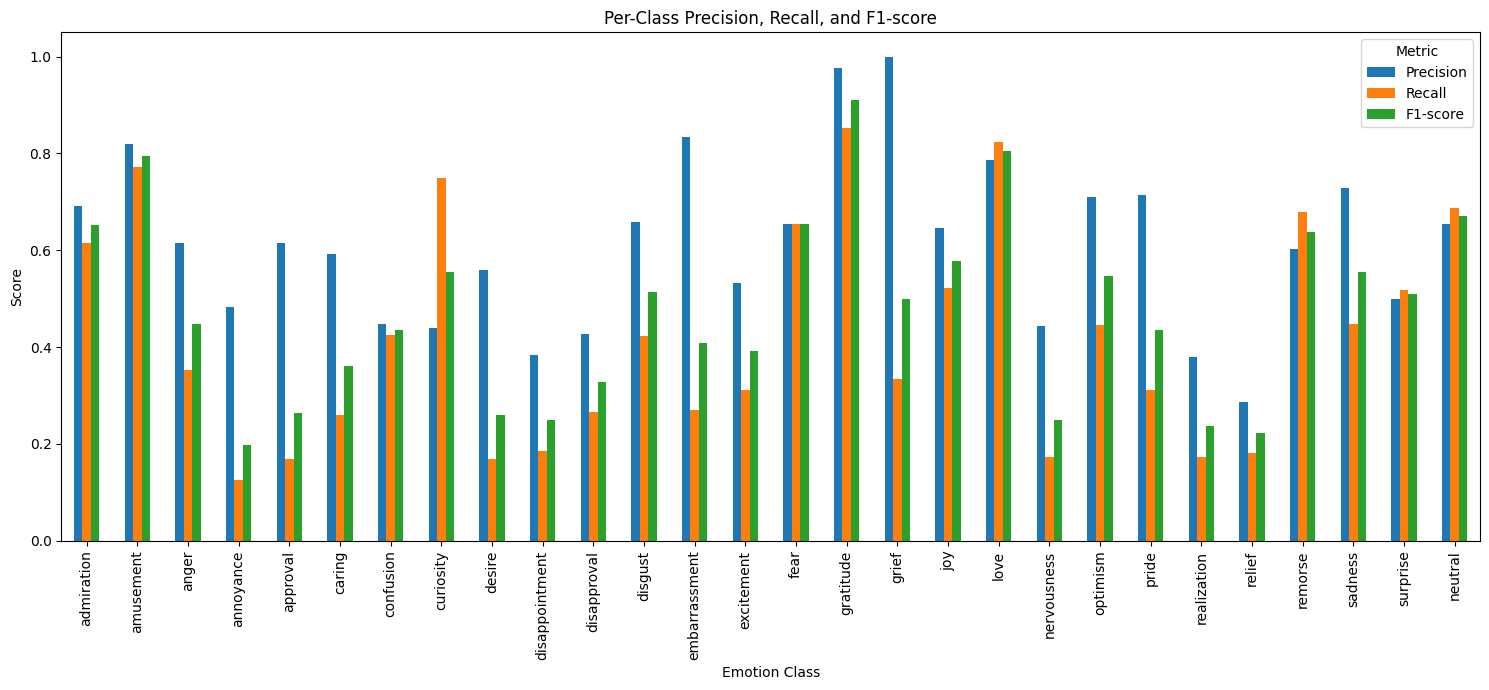

In [ ]:
# 7. Creating a grouped bar chart
ax = per_class_metrics_df.plot(kind='bar', figsize=(15, 7)) # Adjust figsize as needed

# Set title and labels
plt.title('Per-Class Precision, Recall, and F1-score')
plt.xlabel('Emotion Class')
plt.ylabel('Score')
plt.xticks(rotation=90) # Rotate x-axis labels for readability

# Add legend
plt.legend(title='Metric')

# Adjust layout to prevent labels overlapping
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.savefig('per_class_metrics_bar_chart.png') # Save the plot to a file
print("Per-Class Metrics Bar Chart saved as 'per_class_metrics_bar_chart.png'")

# Display the plot
plt.show()

Visualization of the metrics per class.

*   In general, precision seems to be better than recall across majority of classes
*   High performing classes i.e. having all high bars : gratitude, amusement, love
*   Low performing classes i.e. having majority of bars low : relief, annoyance, nervousness, realization



In [ ]:
# 8. Summarizing performance

print("\n--- Model Performance Summary ---")
output_report_file = os.path.join(FLAGS.output_dir, "Performance_Summary.txt")

# Write the summary to a file
with open(output_report_file, 'w') as f:
    f.write("Model Performance Summary:\n\n")

    # Identify emotions with good performance (high F1-score as a balanced metric)
    # Sort by F1-score in descending order
    sorted_metrics = per_class_metrics_df.sort_values(by='F1-score', ascending=False)

    print("\nEmotions the model understands better (higher F1-score):")
    f.write("\nEmotions the model understands better (higher F1-score):\n")
    # Display top N emotions, considering support if needed
    top_n = 10
    print(sorted_metrics.head(top_n))
    f.write(sorted_metrics.head(top_n).to_string()+"\n")

    # Identify emotions the model struggles with (low F1-score)
    print("\nEmotions the model struggles with (lower F1-score):")
    f.write("\nEmotions the model struggles with (lower F1-score):\n")
    # Display bottom N emotions, considering support if needed
    bottom_n = 10
    print(sorted_metrics.tail(bottom_n))
    f.write(sorted_metrics.tail(bottom_n).to_string()+"\n")

print(f"\nPerformance summary also saved to {output_report_file}")



--- Model Performance Summary ---

Emotions the model understands better (higher F1-score):
           Precision    Recall  F1-score
gratitude   0.977199  0.852273   0.91047
love        0.787149  0.823529  0.804928
amusement   0.819277  0.772727  0.795322
neutral     0.653539  0.687185   0.66994
fear        0.653846  0.653846  0.653846
admiration  0.691964  0.615079  0.651261
remorse     0.603175  0.678571  0.638655
joy         0.646154  0.521739   0.57732
sadness     0.729167  0.448718  0.555556
curiosity   0.440083      0.75  0.554688

Emotions the model struggles with (lower F1-score):
               Precision    Recall  F1-score
excitement      0.533333   0.31068  0.392638
caring           0.59322  0.259259  0.360825
disapproval     0.427711  0.265918  0.327945
approval        0.614583  0.168091  0.263982
desire              0.56  0.168675  0.259259
nervousness     0.444444  0.173913      0.25
disappointment  0.383562   0.18543      0.25
realization     0.378788  0.172414  0.23696

## Summary:

### Data Analysis Key Findings

*   The model performs best on emotions like `gratitude, amusement, love, fear, and admiration`, as indicated by their higher F1-scores.
*   The model struggles significantly with emotions such as `annoyance, relief, realization, disappointment, nervousness` which exhibit lower F1-scores.
*   Emotions with very low F1-scores, like `grief and relief`, likely suffer from low True Positives and False Positives due to limited data support and the model's difficulty in predicting these rare instances.
*   Conservative prediction (high precision, low recall) : Model is conservative is predicting emotions like `approval, disappointment`.
*   Aggressive prediction (low precision, high recall) : For emotions like `curiosity`, the model is more aggressive in predicting the emption.
*   The `neutral` emotion has a good F1-score with balanced precision and recall but when we look at the overall confusion matrix for `neutral`, we can see it has a high False Positives and False Negatives showcasing the confusion the model experiences at times, confusing neutral with some other emotion.

### Next Steps

*   Address the low-performing emotion classes (e.g., `annoyance, relief`) by exploring data augmentation techniques or collecting more labeled data for these specific emotions.
*   Investigate potential class imbalance issues and consider resampling techniques (oversampling minority classes, undersampling majority classes) or using different loss functions to improve performance on underrepresented or challenging emotions.


# Compressing the complete output for download

In [ ]:
!zip -r /content/output_data.zip /content

updating: content/ (stored 0%)
updating: content/.config/ (stored 0%)
updating: content/.config/.last_update_check.json (deflated 24%)
updating: content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db (deflated 97%)
updating: content/.config/.last_opt_in_prompt.yaml (stored 0%)
updating: content/.config/.last_survey_prompt.yaml (stored 0%)
updating: content/.config/active_config (stored 0%)
updating: content/.config/gce (stored 0%)
updating: content/.config/default_configs.db (deflated 98%)
updating: content/.config/configurations/ (stored 0%)
updating: content/.config/configurations/config_default (deflated 15%)
updating: content/.config/config_sentinel (stored 0%)
updating: content/.config/logs/ (stored 0%)
updating: content/.config/logs/2025.08.13/ (stored 0%)
updating: content/.config/logs/2025.08.13/13.41.49.317369.log (deflated 58%)
updating: content/.config/logs/2025.08.13/13.41.34.546254.log (deflated 58%)
updating: content/.config/logs/2025.08.13/13.41.0